# ESG and Financial Performance Analysis

This notebook analyzes the relationship between ESG (Environmental, Social, and Governance) scores and financial performance metrics using the "ESG and Financial Performance" dataset. We will explore, preprocess, visualize the data, and then apply various supervised and unsupervised machine learning algorithms implemented in the `Supervised_Learning` and `Unsupervised_Learning` directories.

## Contents:
1.  **Data Loading and Initial Exploration:** Load the dataset and perform basic checks (shape, info, missing values, summary statistics).
2.  **Data Preprocessing and Cleaning:** Handle missing values, encode categorical features, and scale numerical features using the provided utility function.
3.  **Exploratory Data Visualization:** Visualize data distributions and correlations.
4.  **Data Preparation for Machine Learning:** Split data into features (X) and target (y) for regression and classification tasks, and perform train/test splits.
5.  **Supervised Learning:**
    * Regression Task (Predicting ProfitMargin)
        * Linear Regression
        * Decision Tree Regressor
        * K-Nearest Neighbors (KNN) Regressor
        * Random Forest Regressor
        * Neural Network (Regression)
        * Gradient Boosting Regressor
        * Regression Model Comparison
    * Classification Task (Predicting High/Low ESG_Overall)
        * Perceptron
        * Logistic Regression
        * K-Nearest Neighbors (KNN) Classifier
        * Decision Tree Classifier
        * Random Forest Classifier
        * Neural Network (Classification)
        * AdaBoost Classifier
        * Classification Model Comparison
6.  **Unsupervised Learning:**
    * Principal Component Analysis (PCA)
    * K-Means Clustering
    * DBSCAN Clustering
    * Clustering Model Comparison
    * Singular Value Decomposition (SVD) for Image Compression (CIFAR-10 Demo)
    * Label Propagation for Community Detection (Synthetic Graph Demo)
7.  **Conclusion:** Summarize findings.

In [1]:
# Import necessary standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob # For finding image files
import networkx as nx # For Label Propagation Demo
from collections import Counter, defaultdict # For Label Propagation Demo
import random # For Label Propagation Demo

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report,
    silhouette_score
)
from sklearn.decomposition import PCA as SklearnPCA # For comparison/visualization
from sklearn.cluster import DBSCAN as SklearnDBSCAN # For comparison/visualization
from PIL import Image # For SVD image compression section
# import requests # No longer needed if loading local files
# from io import BytesIO # No longer needed

# --- Import custom utilities and algorithms ---
print("Importing utilities...")
from utils.data_preprocessing import preprocess_esg_data, create_feature_target_split
from utils.data_visualization import (
    plot_esg_distributions,
    plot_correlation_matrix,
    plot_financial_metrics,
    plot_esg_vs_financial,
    plot_pca_results,
    plot_clusters,
    plot_regression_results,
    plot_classification_results,
    plot_model_comparison
)

# Supervised Learning Algorithms
print("Importing Supervised Learning models...")
from Supervised_Learning.perceptron import Perceptron
from Supervised_Learning.linear_regression import LinearRegression
from Supervised_Learning.logistic_regression import LogisticRegression
from Supervised_Learning.neural_network import NeuralNetwork
from Supervised_Learning.knn import KNNClassifier, KNNRegressor
from Supervised_Learning.decision_tree import DecisionTreeClassifier, DecisionTreeRegressor
from Supervised_Learning.random_forest import RandomForestClassifier, RandomForestRegressor
from Supervised_Learning.ensemble_methods import AdaBoostClassifier, GradientBoostingRegressor

# Unsupervised Learning Algorithms
print("Importing Unsupervised Learning models...")
from Unsupervised_Learning.kmeans import KMeans
from Unsupervised_Learning.dbscan import DBSCAN
from Unsupervised_Learning.pca import PCA
from Unsupervised_Learning.svd_compression import SVDCompression
from Unsupervised_Learning.label_propagation import LabelPropagation # New import

# Set visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("Libraries and modules imported successfully.")

Importing utilities...
Importing Supervised Learning models...
Importing Unsupervised Learning models...
Libraries and modules imported successfully.


## 1. Data Loading and Initial Exploration

In [2]:
# Define the relative path to the data file
# Assumes the notebook is running in the root directory 'ML_Course_Project'
esg_file_path = "./data/company_esg_financial_dataset.csv"

df_original = None # Initialize df to None

try:
    # Check if the file exists at the specified path
    if os.path.exists(esg_file_path):
        # Load the CSV file into a pandas DataFrame
        df_original = pd.read_csv(esg_file_path)
        print(f"Successfully loaded ESG data from: {esg_file_path}")
    else:
        print(f"Error: File not found at the specified path: {esg_file_path}")
        print("Please ensure the 'data' directory exists and the file 'company_esg_financial_dataset.csv' is inside it.")

except FileNotFoundError:
    print(f"Error: File not found at path: {esg_file_path}")
    print("Please double-check the path and file name.")
except pd.errors.EmptyDataError:
    print(f"Error: The file at {esg_file_path} is empty.")
except Exception as e:
    print(f"An error occurred while loading the ESG file: {e}")

# Proceed with analysis if the DataFrame was loaded successfully
if df_original is not None:
    print(f"\nESG Dataset loaded successfully.")
    print(f"Shape of the DataFrame: {df_original.shape}")
    print("\nFirst 5 records:")
    display(df_original.head())
else:
    print("\nFailed to load ESG dataset. Please check the file path and integrity.")

Successfully loaded ESG data from: ./data/company_esg_financial_dataset.csv

ESG Dataset loaded successfully.
Shape of the DataFrame: (11000, 16)

First 5 records:


,CompanyID,CompanyName,Industry,Region,Year,Revenue,ProfitMargin,MarketCap,GrowthRate,ESG_Overall,ESG_Environmental,ESG_Social,ESG_Governance,CarbonEmissions,WaterUsage,EnergyConsumption
0,1,Company_1,Retail,Latin America,2015,459.2,6.0,337.5,NaN,57.0,60.7,33.5,76.8,35577.4,17788.7,71154.7
1,1,Company_1,Retail,Latin America,2016,473.8,4.6,366.6,3.2,56.7,58.9,32.8,78.5,37314.7,18657.4,74629.4
2,1,Company_1,Retail,Latin America,2017,564.9,5.2,313.4,19.2,56.5,57.6,34.0,77.8,45006.4,22503.2,90012.9
3,1,Company_1,Retail,Latin America,2018,558.4,4.3,283.0,-1.1,58.0,62.3,33.4,78.3,42650.1,21325.1,85300.2
4,1,Company_1,Retail,Latin America,2019,554.5,4.9,538.1,-0.7,56.6,63.7,30.0,76.1,41799.4,20899.7,83598.8


In [3]:
# Get basic information about the dataset
if df_original is not None:
    print("\nESG Dataset Information:")
    df_original.info()


ESG Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CompanyID          11000 non-null  int64  
 1   CompanyName        11000 non-null  object 
 2   Industry           11000 non-null  object 
 3   Region             11000 non-null  object 
 4   Year               11000 non-null  int64  
 5   Revenue            11000 non-null  float64
 6   ProfitMargin       11000 non-null  float64
 7   MarketCap          11000 non-null  float64
 8   GrowthRate         10000 non-null  float64
 9   ESG_Overall        11000 non-null  float64
 10  ESG_Environmental  11000 non-null  float64
 11  ESG_Social         11000 non-null  float64
 12  ESG_Governance     11000 non-null  float64
 13  CarbonEmissions    11000 non-null  float64
 14  WaterUsage         11000 non-null  float64
 15  EnergyConsumption  11000 non-null  float64
d

In [4]:
# Check for missing values
if df_original is not None:
    missing_values = df_original.isnull().sum()
    missing_percentage = (missing_values / len(df_original)) * 100
    missing_df = pd.DataFrame({
        'Missing Values': missing_values,
        'Percentage': missing_percentage
    })
    print("\nMissing Values Analysis:")
    display(missing_df[missing_df['Missing Values'] > 0].sort_values('Missing Values', ascending=False))


Missing Values Analysis:


,Missing Values,Percentage
GrowthRate,1000,9.090909


*Observation:* The `GrowthRate` column has 1000 missing values (9.1%), corresponding to the first year (2015) for each company where year-over-year growth cannot be calculated. All other columns are complete.

In [5]:
# Summary statistics of numerical columns
if df_original is not None:
    print("\nSummary Statistics:")
    display(df_original.describe())


Summary Statistics:


,CompanyID,Year,Revenue,ProfitMargin,MarketCap,GrowthRate,ESG_Overall,ESG_Environmental,ESG_Social,ESG_Governance,CarbonEmissions,WaterUsage,EnergyConsumption
count,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,10000.000000,11000.000000,11000.000000,11000.000000,11000.000000,1.100000e+04,1.100000e+04,1.100000e+04
mean,500.500000,2020.000000,4670.850591,10.900455,13380.622236,4.830370,54.615273,56.416991,55.660582,51.767655,1.271462e+06,5.600442e+05,1.165839e+07
std,288.688113,3.162421,9969.954369,8.758711,39922.870373,9.424787,15.893937,26.767233,23.356152,25.323370,5.067760e+06,1.565686e+06,5.095836e+07
min,1.000000,2015.000000,35.900000,-20.000000,1.800000,-36.000000,6.300000,0.000000,0.000000,0.000000,2.042200e+03,1.021100e+03,5.105500e+03
25%,250.750000,2017.000000,938.775000,5.300000,1098.525000,-1.325000,44.100000,34.700000,37.600000,30.775000,1.228530e+05,6.488467e+04,3.069161e+05
50%,500.500000,2020.000000,1902.300000,10.500000,3096.450000,4.900000,54.600000,55.600000,55.150000,52.100000,2.920734e+05,2.038805e+05,1.221745e+06
75%,750.250000,2023.000000,4342.625000,16.300000,9995.500000,11.000000,65.600000,79.000000,73.800000,73.000000,7.407311e+05,5.251880e+05,5.616437e+06
max,1000.000000,2025.000000,180810.400000,50.000000,865271.700000,38.000000,98.800000,100.000000,100.000000,100.000000,1.741047e+08,5.223142e+07,1.741047e+09


In [6]:
# Check unique values in categorical columns
if df_original is not None:
    categorical_cols = df_original.select_dtypes(include=['object']).columns
    print("\nUnique values in categorical columns:")
    for col in categorical_cols:
        print(f"--- {col} ({df_original[col].nunique()} unique) ---")
        # Only print value counts if not too many unique values
        if df_original[col].nunique() < 15:
             print(df_original[col].value_counts())
        else:
             print(f"(Showing first 5 unique: {df_original[col].unique()[:5]}...)")
        print()


Unique values in categorical columns:
--- CompanyName (1000 unique) ---
(Showing first 5 unique: ['Company_1' 'Company_2' 'Company_3' 'Company_4' 'Company_5']...)

--- Industry (9 unique) ---
Industry
Healthcare        1331
Transportation    1287
Manufacturing     1287
Consumer Goods    1276
Finance           1243
Energy            1188
Utilities         1177
Retail            1166
Technology        1045
Name: count, dtype: int64

--- Region (7 unique) ---
Region
Asia             1672
Oceania          1661
Middle East      1617
Europe           1540
North America    1540
Latin America    1507
Africa           1463
Name: count, dtype: int64



## 2. Data Preprocessing and Cleaning

We will use the `preprocess_esg_data` function from `utils.data_preprocessing`. This function handles:
1.  **Missing Value Imputation:** Uses median for numerical features (`GrowthRate`) and mode for categorical features.
2.  **Categorical Encoding:** Converts `Industry` and `Region` into numerical representations using Label Encoding.
3.  **Feature Scaling:** Standardizes numerical features to have zero mean and unit variance using `StandardScaler`.
4.  **Outlier Handling (Optional):** Identifies potential outliers using IQR (but doesn't remove them by default in the provided utility).

In [7]:
if df_original is not None:
    # Apply preprocessing
    # Drop CompanyID and CompanyName as they are identifiers
    # Keep 'Year' for potential time-series analysis later, but it will be scaled.
    # If using models sensitive to time ordering, handle 'Year' differently.
    df_processed = preprocess_esg_data(df_original.drop(columns=['CompanyID', 'CompanyName']))

    print("\nDataset shape after preprocessing:", df_processed.shape)
    print("\nFirst 5 rows of preprocessed data:")
    display(df_processed.head())

    print("\nChecking for missing values after preprocessing:")
    print(f"Total missing values: {df_processed.isnull().sum().sum()}") # Should be 0

    print("\nData types after preprocessing:")
    # All columns should be numerical now
    df_processed.info()
else:
    print("Original DataFrame not loaded. Cannot preprocess.")

Starting preprocessing...
Filled missing values in numerical column 'GrowthRate' with median (4.9).
Label encoded categorical column 'Industry'.
Label encoded categorical column 'Region'.
Identified 2954 rows with outliers based on IQR method in columns: Year, Revenue, ProfitMargin, MarketCap, GrowthRate, ESG_Overall, ESG_Environmental, ESG_Social, ESG_Governance, CarbonEmissions, WaterUsage, EnergyConsumption.
Scaled numerical columns: Industry, Region, Year, Revenue, ProfitMargin, MarketCap, GrowthRate, ESG_Overall, ESG_Environmental, ESG_Social, ESG_Governance, CarbonEmissions, WaterUsage, EnergyConsumption.
Preprocessing finished.

Dataset shape after preprocessing: (11000, 14)

First 5 rows of preprocessed data:


,Industry,Region,Year,Revenue,ProfitMargin,MarketCap,GrowthRate,ESG_Overall,ESG_Environmental,ESG_Social,ESG_Governance,CarbonEmissions,WaterUsage,EnergyConsumption
0,0.4111,-0.018478,-1.581139,-0.422453,-0.559520,-0.326723,0.007044,0.150047,0.160017,-0.948854,0.988553,-0.243883,-0.346353,-0.227397
1,0.4111,-0.018478,-1.264911,-0.420989,-0.719369,-0.325994,-0.182144,0.131171,0.092767,-0.978827,1.055687,-0.243540,-0.345798,-0.227329
2,0.4111,-0.018478,-0.948683,-0.411851,-0.650862,-0.327327,1.598452,0.118587,0.044198,-0.927446,1.028044,-0.242022,-0.343342,-0.227027
3,0.4111,-0.018478,-0.632456,-0.412503,-0.753622,-0.328088,-0.660679,0.212967,0.219794,-0.953136,1.047789,-0.242487,-0.344094,-0.227119
4,0.4111,-0.018478,-0.316228,-0.412894,-0.685115,-0.321698,-0.616164,0.124879,0.272099,-1.098715,0.960909,-0.242655,-0.344366,-0.227153



Checking for missing values after preprocessing:
Total missing values: 0

Data types after preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Industry           11000 non-null  float64
 1   Region             11000 non-null  float64
 2   Year               11000 non-null  float64
 3   Revenue            11000 non-null  float64
 4   ProfitMargin       11000 non-null  float64
 5   MarketCap          11000 non-null  float64
 6   GrowthRate         11000 non-null  float64
 7   ESG_Overall        11000 non-null  float64
 8   ESG_Environmental  11000 non-null  float64
 9   ESG_Social         11000 non-null  float64
 10  ESG_Governance     11000 non-null  float64
 11  CarbonEmissions    11000 non-null  float64
 12  WaterUsage         11000 non-null  float64
 13  EnergyConsumption  11000 non-null  float64
dtypes: float64(

## 3. Exploratory Data Visualization (on Processed Data)

Visualizing the processed data helps understand distributions after scaling and encoding.

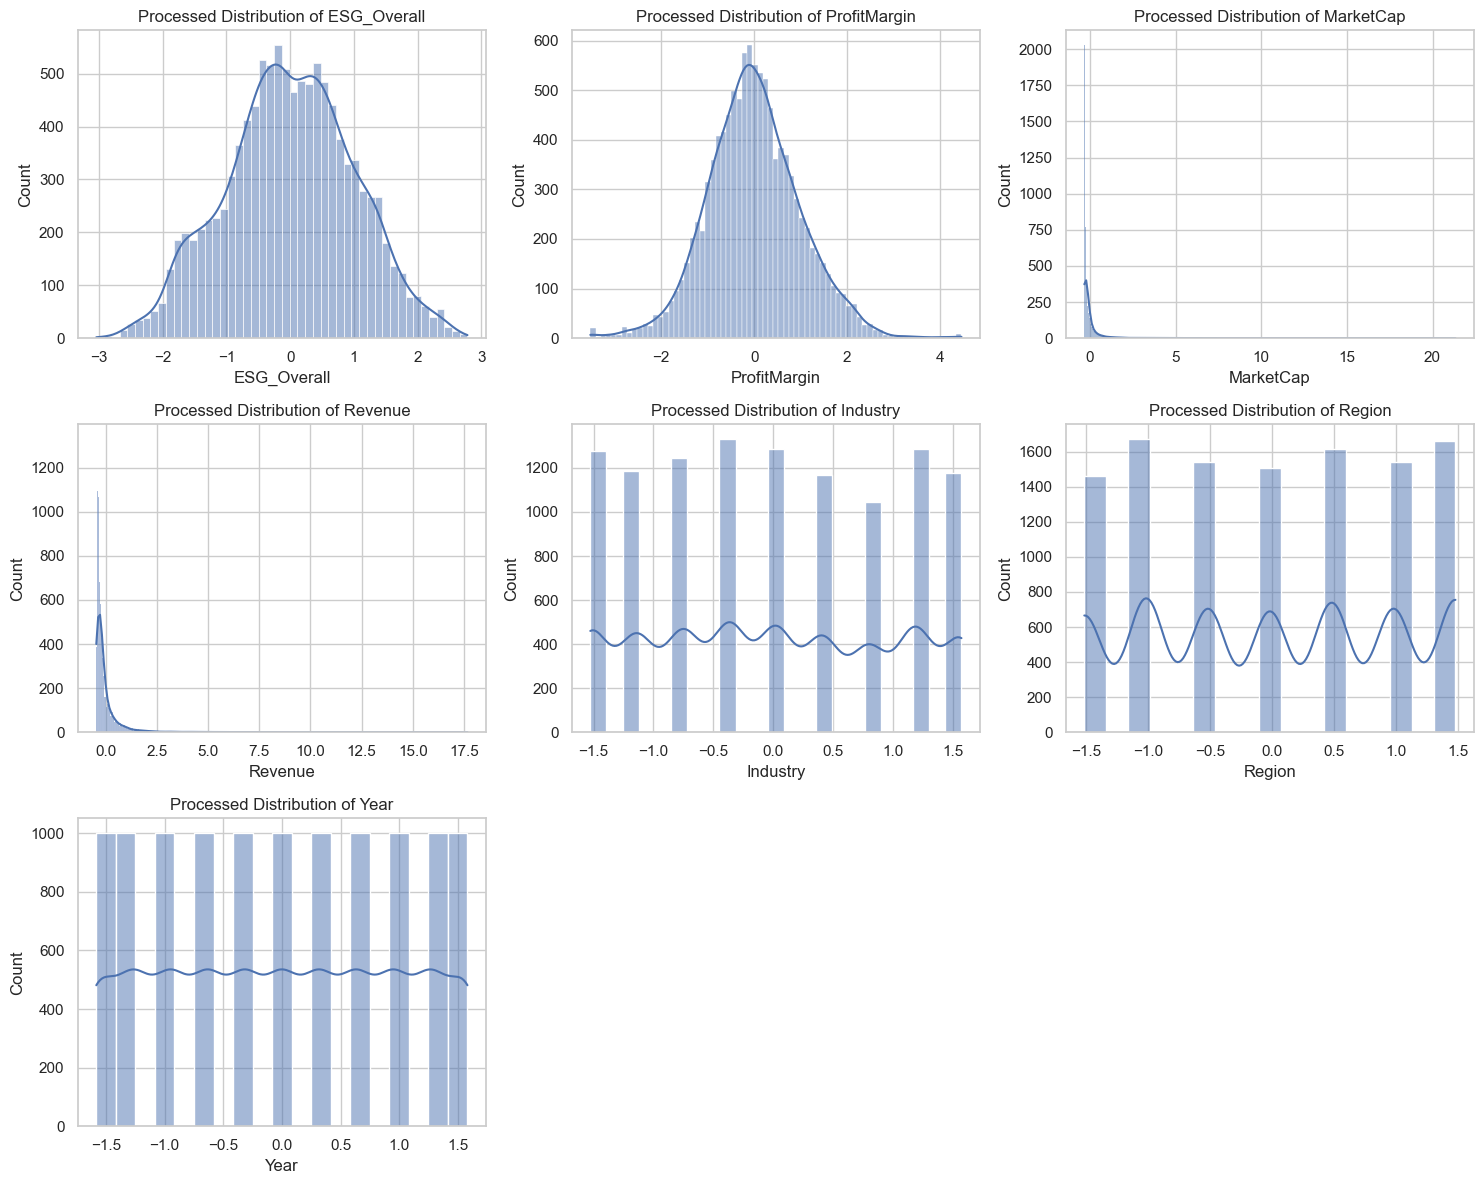

In [8]:
# Visualize distributions of key processed features
if 'df_processed' in locals():
    plot_cols = ['ESG_Overall', 'ProfitMargin', 'MarketCap', 'Revenue', 'Industry', 'Region', 'Year']
    # Filter out columns that might not exist if preprocessing failed
    plot_cols = [col for col in plot_cols if col in df_processed.columns]

    if plot_cols:
        n_cols_viz = 3
        n_rows_viz = (len(plot_cols) + n_cols_viz - 1) // n_cols_viz
        plt.figure(figsize=(n_cols_viz * 5, n_rows_viz * 4))
        for i, col in enumerate(plot_cols):
            plt.subplot(n_rows_viz, n_cols_viz, i + 1)
            sns.histplot(df_processed[col], kde=True)
            plt.title(f'Processed Distribution of {col}')
        plt.tight_layout()
        plt.show()
    else:
        print("No columns selected for visualization or df_processed is missing.")
else:
    print("DataFrame df_processed not found. Skipping visualizations.")

Plotting Correlation Matrix (Method: pearson)...


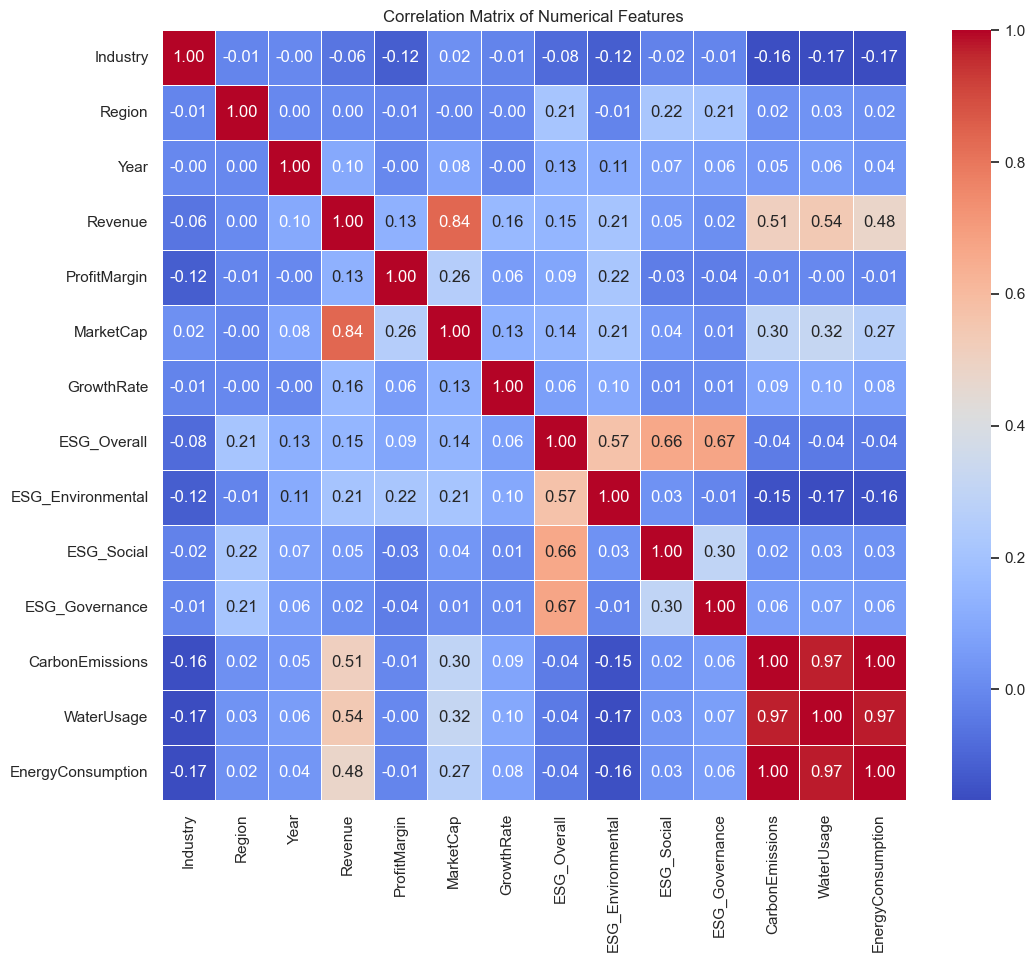

In [9]:
# Correlation heatmap for processed numerical columns
if 'df_processed' in locals():
    plot_correlation_matrix(df_processed)
else:
    print("DataFrame df_processed not found. Skipping correlation matrix.")

## 4. Data Preparation for Machine Learning

We'll define features (X) and targets (y) for our supervised learning tasks.

**Tasks:**
1.  **Regression:** Predict `ProfitMargin`. 
    * *Alternative Regression Targets:* `MarketCap`, `ESG_Overall`.
2.  **Classification:** Predict whether `ESG_Overall` score is 'High' (above median) or 'Low' (below or equal to median).
    * *Alternative Classification Targets:* `Industry`, `Region` (multi-class), or categories based on financial metrics.

*Note:* We will proceed with `ProfitMargin` for regression and the binary `ESG_Category` for classification for this analysis.

In [10]:
if 'df_processed' in locals() and df_original is not None:
    # --- Regression Task --- 
    target_reg = 'ProfitMargin'
    # Use all other columns as features
    features_reg = df_processed.drop(columns=[target_reg]).columns.tolist()

    X_reg = df_processed[features_reg]
    y_reg = df_processed[target_reg]

    # Train-test split for regression
    X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
        X_reg, y_reg, test_size=0.2, random_state=42
    )
    print(f"Regression Task (Target: {target_reg})")
    print(f"Features shape: {X_reg.shape}, Target shape: {y_reg.shape}")
    print(f"Train shapes: {X_reg_train.shape}, {y_reg_train.shape}")
    print(f"Test shapes: {X_reg_test.shape}, {y_reg_test.shape}")

    # --- Classification Task --- 
    # Create a binary target based on the median ESG_Overall score
    # Use the *original* non-scaled ESG_Overall to determine the median for interpretability
    if 'ESG_Overall' in df_original.columns:
        # Calculate median on the original scale
        median_esg_original = df_original['ESG_Overall'].median()
        print(f"\nMedian ESG_Overall (original scale) for classification split: {median_esg_original:.2f}")

        # Create category based on the original scale ESG score
        # We add this column to the *processed* dataframe for convenience
        df_processed['ESG_Category'] = (df_original['ESG_Overall'] > median_esg_original).astype(int)

        target_clf = 'ESG_Category'
        # Use all columns except the target, the original ESG score it's derived from, and potentially ProfitMargin if it was the regression target
        # For simplicity, let's exclude ProfitMargin and ESG_Overall from classification features
        features_clf = df_processed.drop(columns=[target_clf, 'ESG_Overall', 'ProfitMargin']).columns.tolist()

        X_clf = df_processed[features_clf]
        y_clf = df_processed[target_clf]

        # Train-test split for classification
        X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
            X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf # Stratify for classification
        )
        print(f"\nClassification Task (Target: {target_clf} based on ESG_Overall > {median_esg_original:.2f})")
        print(f"Features shape: {X_clf.shape}, Target shape: {y_clf.shape}")
        print(f"Train shapes: {X_clf_train.shape}, {y_clf_train.shape}")
        print(f"Test shapes: {X_clf_test.shape}, {y_clf_test.shape}")
        print(f"Target distribution (0=Low ESG, 1=High ESG):\n{df_processed[target_clf].value_counts(normalize=True)}")

        # Remove the temporary target column from df_processed if needed elsewhere
        # df_processed = df_processed.drop(columns=[target_clf])
    else:
        print("\nWarning: 'ESG_Overall' column not found in original data for classification task setup.")
        X_clf_train, X_clf_test, y_clf_train, y_clf_test = [None]*4

    # --- Data for Unsupervised Learning --- 
    # Typically use all relevant features (excluding created target variables)
    # Use the original processed features before adding ESG_Category
    unsupervised_features = features_reg # Using the set of features from regression is a good start
    X_unsupervised = df_processed[unsupervised_features]
    print(f"\nUnsupervised Learning - Data shape: {X_unsupervised.shape}")

else:
    print("\nDataFrame df_processed or df_original not found. Skipping data preparation.")

Regression Task (Target: ProfitMargin)
Features shape: (11000, 13), Target shape: (11000,)
Train shapes: (8800, 13), (8800,)
Test shapes: (2200, 13), (2200,)

Median ESG_Overall (original scale) for classification split: 54.60

Classification Task (Target: ESG_Category based on ESG_Overall > 54.60)
Features shape: (11000, 12), Target shape: (11000,)
Train shapes: (8800, 12), (8800,)
Test shapes: (2200, 12), (2200,)
Target distribution (0=Low ESG, 1=High ESG):
ESG_Category
0    0.500909
1    0.499091
Name: proportion, dtype: float64

Unsupervised Learning - Data shape: (11000, 13)


## 5. Supervised Learning

We will now apply the implemented supervised learning algorithms to the prepared datasets.

### 5.1 Regression Task (Predicting ProfitMargin)

#### 5.1.1 Linear Regression

--- Linear Regression (Normal Equation) ---
Mean Squared Error: 0.9331
R^2 Score: 0.1009

--- Linear Regression (Gradient Descent) ---
Mean Squared Error: 0.9284
R^2 Score: 0.1055
Plotting Regression Results: Linear Regression (Normal Eq.) Predictions...


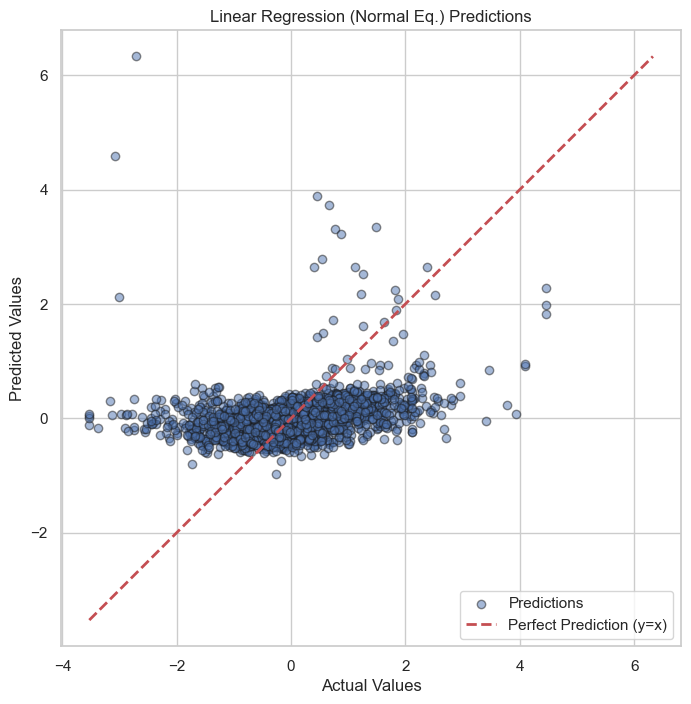

In [11]:
regression_results = {} # Initialize dict to store results

if 'X_reg_train' in locals() and X_reg_train is not None:
    print("--- Linear Regression (Normal Equation) ---")
    lr_normal = LinearRegression(method='normal_equation')
    lr_normal.fit(X_reg_train, y_reg_train)
    y_reg_pred_normal = lr_normal.predict(X_reg_test)
    mse_normal = mean_squared_error(y_reg_test, y_reg_pred_normal)
    r2_normal = r2_score(y_reg_test, y_reg_pred_normal)
    print(f"Mean Squared Error: {mse_normal:.4f}")
    print(f"R^2 Score: {r2_normal:.4f}")
    regression_results['Linear Regression (Normal Eq.)'] = {'MSE': mse_normal, 'R2': r2_normal}

    print("\n--- Linear Regression (Gradient Descent) ---")
    # Scale learning rate based on number of features if needed, or tune it
    lr_gd = LinearRegression(method='gradient_descent', learning_rate=0.01, n_iterations=1000)
    # Ensure data is numpy for GD implementation if necessary
    lr_gd.fit(X_reg_train.values, y_reg_train.values)
    y_reg_pred_gd = lr_gd.predict(X_reg_test.values)
    mse_gd = mean_squared_error(y_reg_test, y_reg_pred_gd)
    r2_gd = r2_score(y_reg_test, y_reg_pred_gd)
    print(f"Mean Squared Error: {mse_gd:.4f}")
    print(f"R^2 Score: {r2_gd:.4f}")
    regression_results['Linear Regression (GD)'] = {'MSE': mse_gd, 'R2': r2_gd}

    # Visualization (Actual vs Predicted for Normal Equation)
    plot_regression_results(y_reg_test, y_reg_pred_normal, 'Linear Regression (Normal Eq.) Predictions')
else:
    print("Regression data not prepared. Skipping Linear Regression.")

#### 5.1.2 Decision Tree Regressor

--- Decision Tree Regressor ---
Mean Squared Error: 0.5525
R^2 Score: 0.4676
Plotting Regression Results: Decision Tree Regressor Predictions...


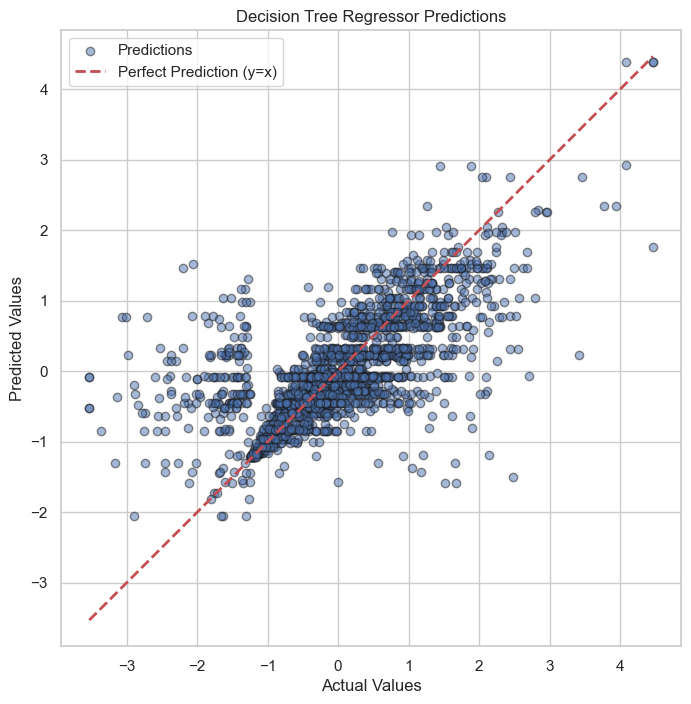

In [12]:
if 'X_reg_train' in locals() and X_reg_train is not None:
    print("--- Decision Tree Regressor ---")
    # Tune hyperparameters like max_depth, min_samples_split
    dt_reg = DecisionTreeRegressor(max_depth=8, min_samples_split=20, random_state=42)
    dt_reg.fit(X_reg_train, y_reg_train)
    y_reg_pred_dt = dt_reg.predict(X_reg_test)
    mse_dt = mean_squared_error(y_reg_test, y_reg_pred_dt)
    r2_dt = r2_score(y_reg_test, y_reg_pred_dt)
    print(f"Mean Squared Error: {mse_dt:.4f}")
    print(f"R^2 Score: {r2_dt:.4f}")

    regression_results['Decision Tree Regressor'] = {'MSE': mse_dt, 'R2': r2_dt}
    plot_regression_results(y_reg_test, y_reg_pred_dt, 'Decision Tree Regressor Predictions')
else:
    print("Regression data not prepared. Skipping Decision Tree Regressor.")

**Discussion (Decision Tree Regressor):** The Decision Tree Regressor achieved a Mean Squared Error (MSE) of 0.5525 and an R² score of 0.4676, highlighting its performance. 

#### 5.1.3 K-Nearest Neighbors (KNN) Regressor

--- KNN Regressor ---
Mean Squared Error: 0.5150
R^2 Score: 0.5038
Plotting Regression Results: KNN Regressor Predictions...


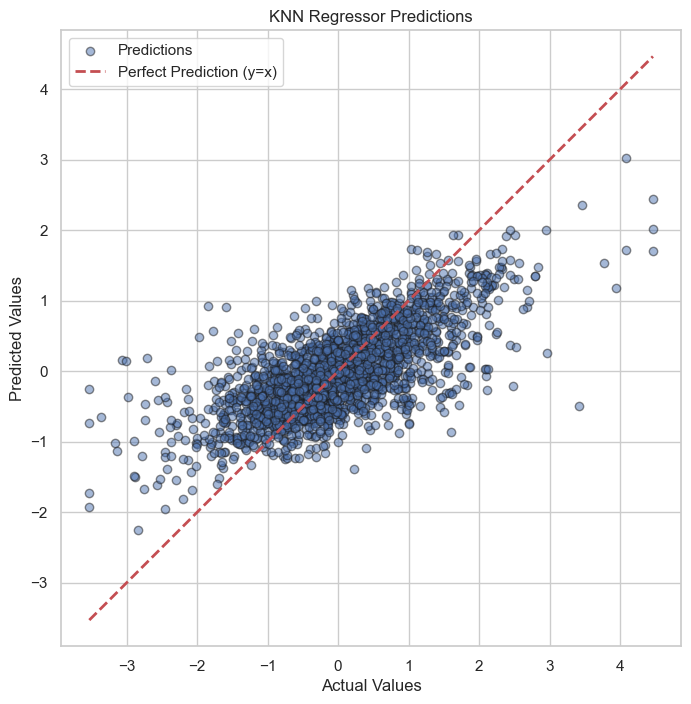

In [13]:
if 'X_reg_train' in locals() and X_reg_train is not None:
    print("--- KNN Regressor ---")
    # Tune n_neighbors
    knn_reg = KNNRegressor(n_neighbors=9, weights='distance')
    knn_reg.fit(X_reg_train, y_reg_train)
    y_reg_pred_knn = knn_reg.predict(X_reg_test)
    mse_knn = mean_squared_error(y_reg_test, y_reg_pred_knn)
    r2_knn = r2_score(y_reg_test, y_reg_pred_knn)
    print(f"Mean Squared Error: {mse_knn:.4f}")
    print(f"R^2 Score: {r2_knn:.4f}")

    regression_results['KNN Regressor'] = {'MSE': mse_knn, 'R2': r2_knn}
    plot_regression_results(y_reg_test, y_reg_pred_knn, 'KNN Regressor Predictions')
else:
    print("Regression data not prepared. Skipping KNN Regressor.")

**Discussion (KNN Regressor):** The KNN Regressor achieved a Mean Squared Error (MSE) of 0.5150 and an R² score of 0.5038, highlighting its performance. 

#### 5.1.4 Random Forest Regressor

--- Random Forest Regressor ---
Mean Squared Error: 0.4351
R^2 Score: 0.5808
Plotting Regression Results: Random Forest Regressor Predictions...


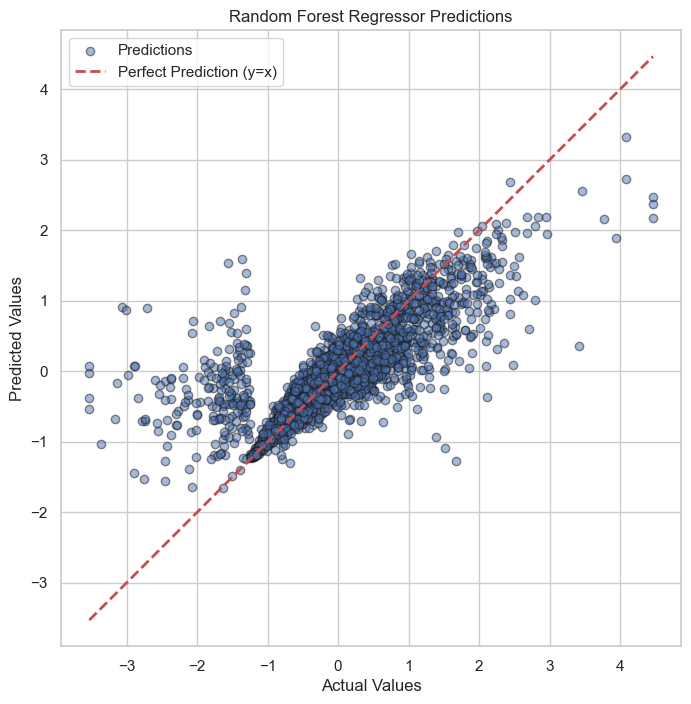

In [ ]:
if 'X_reg_train' in locals() and X_reg_train is not None:
    print("--- Random Forest Regressor ---")
    # Tune n_estimators, max_depth, etc.
    rf_reg = RandomForestRegressor(n_estimators=30, max_depth=7, min_samples_split=20, random_state=42)
    rf_reg.fit(X_reg_train, y_reg_train)
    y_reg_pred_rf = rf_reg.predict(X_reg_test)
    mse_rf = mean_squared_error(y_reg_test, y_reg_pred_rf)
    r2_rf = r2_score(y_reg_test, y_reg_pred_rf)
    print(f"Mean Squared Error: {mse_rf:.4f}")
    print(f"R^2 Score: {r2_rf:.4f}")

    regression_results['Random Forest Regressor'] = {'MSE': mse_rf, 'R2': r2_rf}
    plot_regression_results(y_reg_test, y_reg_pred_rf, 'Random Forest Regressor Predictions')
else:
    print("Regression data not prepared. Skipping Random Forest Regressor.")

**Discussion (Random Forest Regressor):** The Random Forest Regressor achieved a Mean Squared Error (MSE) of 0.4351 and an R² score of 0.5808, highlighting its performance. Ensemble methods demonstrate strong predictive ability on this dataset.

#### 5.1.5 Neural Network (Regression)


--- Neural Network (Regression) ---
Iteration 100/800, Loss: 0.580743
Iteration 200/800, Loss: 0.514452
Iteration 300/800, Loss: 0.481432
Iteration 400/800, Loss: 0.461576
Iteration 500/800, Loss: 0.445405
Iteration 600/800, Loss: 0.430654
Iteration 700/800, Loss: 0.419612
Iteration 800/800, Loss: 0.410661

Final Results for Neural Network Regression:
Mean Squared Error: 0.5753
R^2 Score: 0.4457
Plotting Regression Results: Neural Network Regressor Predictions...


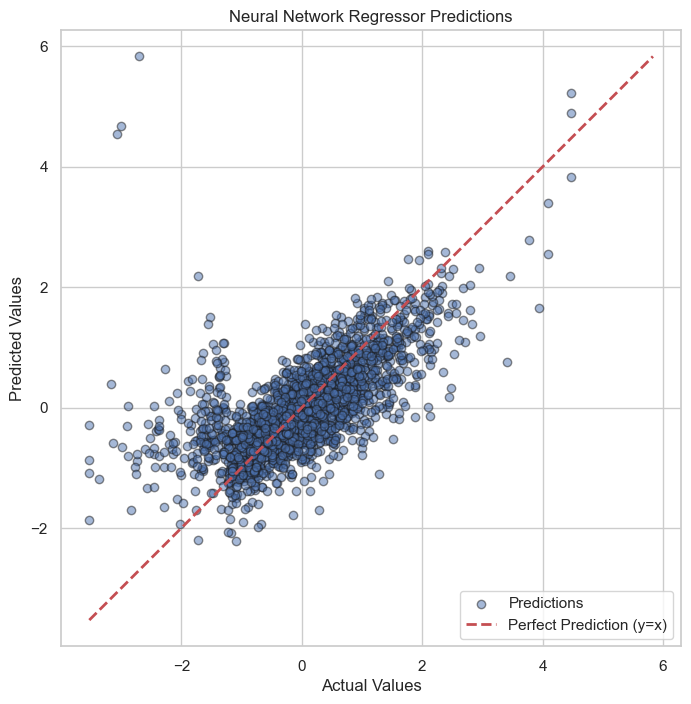

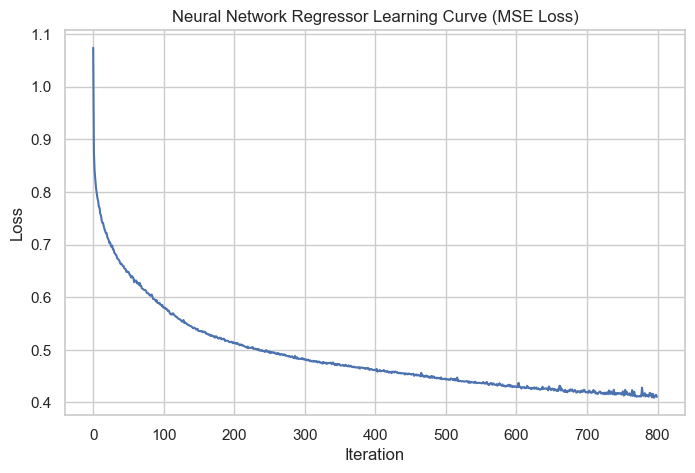

In [15]:
if 'X_reg_train' in locals() and X_reg_train is not None:
    print("\n--- Neural Network (Regression) ---")
    # Initialize NN for regression task
    nn_reg = NeuralNetwork(hidden_layer_size=64,
                           task_type='regression', # Specify regression task
                           activation='relu',
                           learning_rate=0.005, # Learning rate might need tuning for regression
                           n_iterations=800,
                           batch_size=64,
                           random_state=42,
                           verbose=True,
                           print_every=100)

    # NN fit method expects numpy arrays
    nn_reg.fit(X_reg_train.values, y_reg_train.values)

    # Predict on test set
    y_reg_pred_nn = nn_reg.predict(X_reg_test.values)

    # Evaluate
    mse_nn = mean_squared_error(y_reg_test, y_reg_pred_nn)
    r2_nn = r2_score(y_reg_test, y_reg_pred_nn)
    print(f"\nFinal Results for Neural Network Regression:")
    print(f"Mean Squared Error: {mse_nn:.4f}")
    print(f"R^2 Score: {r2_nn:.4f}")

    # Store results
    regression_results['Neural Network Regressor'] = {'MSE': mse_nn, 'R2': r2_nn}

    # Plot results
    # Note: plot_regression_results takes y_true, y_pred, title
    plot_regression_results(y_reg_test, y_reg_pred_nn, 'Neural Network Regressor Predictions')

    # Optional: Plot learning curve (loss vs iterations)
    if hasattr(nn_reg, 'losses') and nn_reg.losses:
        plt.figure(figsize=(8, 5))
        plt.plot(nn_reg.losses)
        plt.title('Neural Network Regressor Learning Curve (MSE Loss)')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

else:
     print("Regression data not prepared. Skipping Neural Network Regressor.")

**Discussion (Neural Network (Regression)):** The Neural Network (Regression) achieved a Mean Squared Error (MSE) of 0.5753 and an R² score of 0.4457, highlighting its performance. 

#### 5.1.6 Gradient Boosting Regressor

--- Gradient Boosting Regressor ---
Mean Squared Error: 0.4426
R^2 Score: 0.5736
Plotting Regression Results: Gradient Boosting Regressor Predictions...


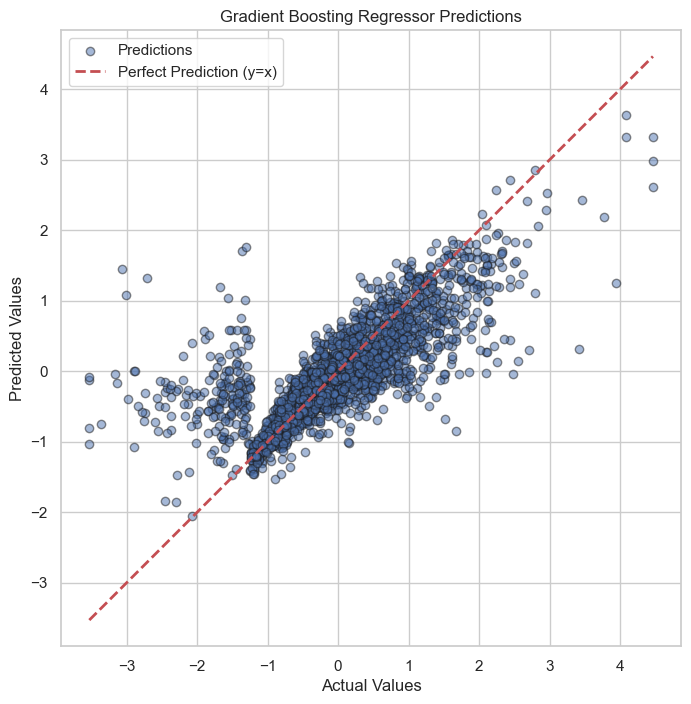

In [16]:
if 'X_reg_train' in locals() and X_reg_train is not None:
    print("--- Gradient Boosting Regressor ---")
    # Tune parameters
    gb_reg = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
    gb_reg.fit(X_reg_train, y_reg_train)
    y_reg_pred_gb = gb_reg.predict(X_reg_test)
    mse_gb = mean_squared_error(y_reg_test, y_reg_pred_gb)
    r2_gb = r2_score(y_reg_test, y_reg_pred_gb)
    print(f"Mean Squared Error: {mse_gb:.4f}")
    print(f"R^2 Score: {r2_gb:.4f}")

    regression_results['Gradient Boosting Regressor'] = {'MSE': mse_gb, 'R2': r2_gb}
    plot_regression_results(y_reg_test, y_reg_pred_gb, 'Gradient Boosting Regressor Predictions')
else:
    print("Regression data not prepared. Skipping Gradient Boosting Regressor.")

**Discussion (Gradient Boosting Regressor):** The Gradient Boosting Regressor achieved a Mean Squared Error (MSE) of 0.4426 and an R² score of 0.5736, highlighting its performance. Ensemble methods demonstrate strong predictive ability on this dataset.

#### 5.1.7 Regression Model Comparison

Plotting Model Comparison: Regression Model Comparison - MSE (Lower is Better) (Metric: MSE)


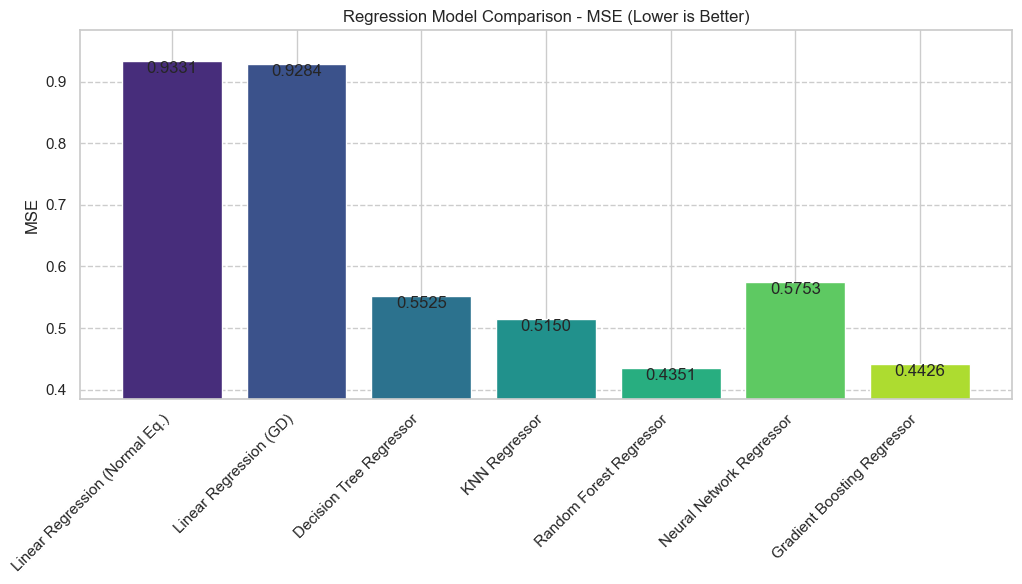

Plotting Model Comparison: Regression Model Comparison - R^2 Score (Higher is Better) (Metric: R2)


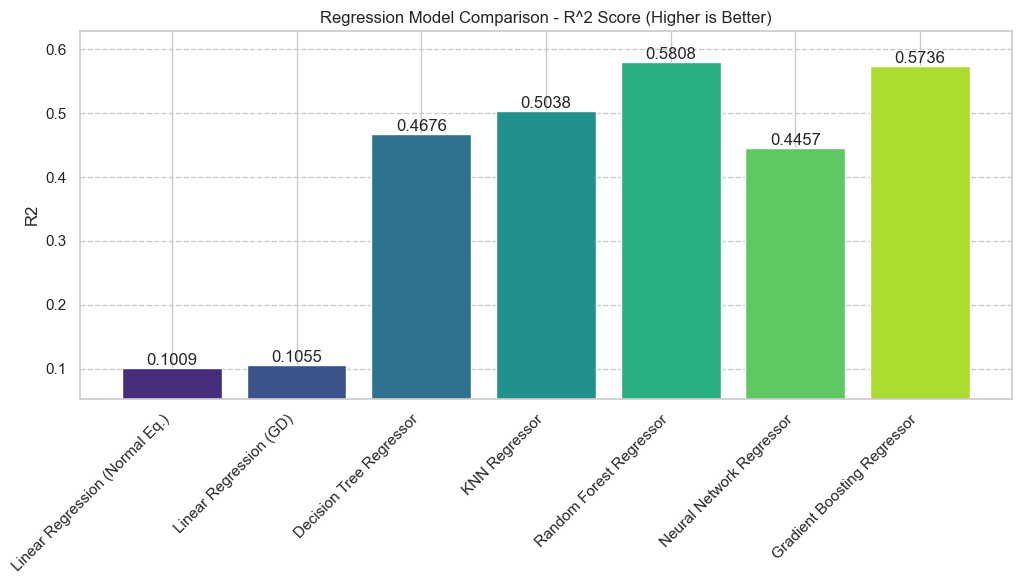

In [17]:
if 'regression_results' in locals() and regression_results:
    # Compare using MSE (lower is better)
    plot_model_comparison(regression_results, 
                          'Regression Model Comparison - MSE (Lower is Better)', 
                          metric='MSE', 
                          higher_is_better=False)
    
    # Compare using R^2 (higher is better)
    plot_model_comparison(regression_results, 
                          'Regression Model Comparison - R^2 Score (Higher is Better)', 
                          metric='R2', 
                          higher_is_better=True)
else:
    print("No regression results to compare.")

**Discussion (Regression Model Comparison):** Among all regression models, the Random Forest Regressor provided the lowest MSE and highest R², followed closely by Gradient Boosting. KNN and Decision Tree showed moderate performance, while the Neural Network underperformed relative to tree-based methods.

### 5.2 Classification Task (Predicting High/Low ESG_Overall)

#### 5.2.1 Perceptron

--- Perceptron ---
Accuracy: 0.9927
F1 Score: 0.9927
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1102
           1       0.99      0.99      0.99      1098

    accuracy                           0.99      2200
   macro avg       0.99      0.99      0.99      2200
weighted avg       0.99      0.99      0.99      2200

Plotting Classification Results: Perceptron...


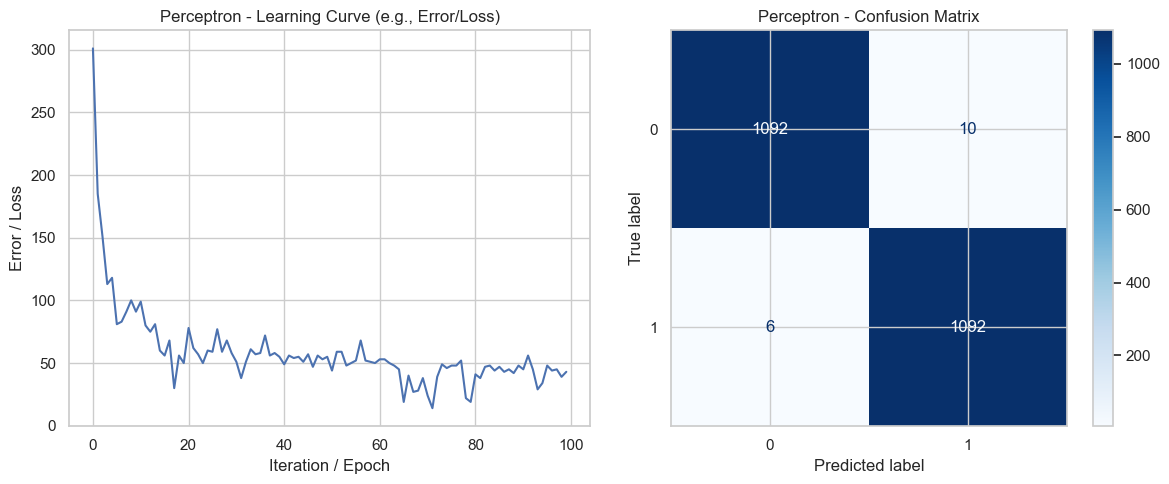

In [18]:
# --- Perceptron ---
classification_results = {} # Initialize dict for classification results - Ensure this is initialized appropriately if continuing from previous cells

if 'X_clf_train' in locals() and X_clf_train is not None:
    print("--- Perceptron ---")
    # Note: Perceptron expects labels -1 and 1. Our target (y_clf) is 0 and 1.
    # We need to map y_clf_train and y_clf_test for fitting.
    y_clf_train_perceptron = y_clf_train # Use original labels
    y_clf_test_perceptron_true = y_clf_test # Use original labels

    perceptron = Perceptron(learning_rate=0.01, n_iterations=100, random_state=42)
    perceptron.fit(X_clf_train, y_clf_train_perceptron) # Fit with appropriate labels

    # Predict using original labels (Perceptron's predict should return 0/1 as per the class code)
    y_clf_pred_perceptron = perceptron.predict(X_clf_test)

    # Evaluate using original 0/1 labels
    acc_perceptron = accuracy_score(y_clf_test, y_clf_pred_perceptron)
    # Add zero_division=0 to handle potential warnings in classification_report
    f1_perceptron = f1_score(y_clf_test, y_clf_pred_perceptron, zero_division=0)
    print(f"Accuracy: {acc_perceptron:.4f}")
    print(f"F1 Score: {f1_perceptron:.4f}")
    print("Classification Report:\n", classification_report(y_clf_test, y_clf_pred_perceptron, zero_division=0))

    # Store results
    classification_results['Perceptron'] = {'Accuracy': acc_perceptron, 'F1': f1_perceptron}

    # Plot results (confusion matrix and optional error history)
    # CORRECTED: Access 'errors' instead of 'errors_'
    plot_classification_results(y_clf_test, y_clf_pred_perceptron, 'Perceptron', history=perceptron.errors)
else:
    print("Classification data not prepared. Skipping Perceptron.")

**Discussion (Perceptron):** The Perceptron achieved an accuracy of 0.9927 and an F1 score of 0.9927, indicating excellent classification performance.

#### 5.2.2 Logistic Regression

--- Logistic Regression ---
Accuracy: 0.9914
F1 Score: 0.9913
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1102
           1       0.99      0.99      0.99      1098

    accuracy                           0.99      2200
   macro avg       0.99      0.99      0.99      2200
weighted avg       0.99      0.99      0.99      2200

Plotting Classification Results: Logistic Regression...


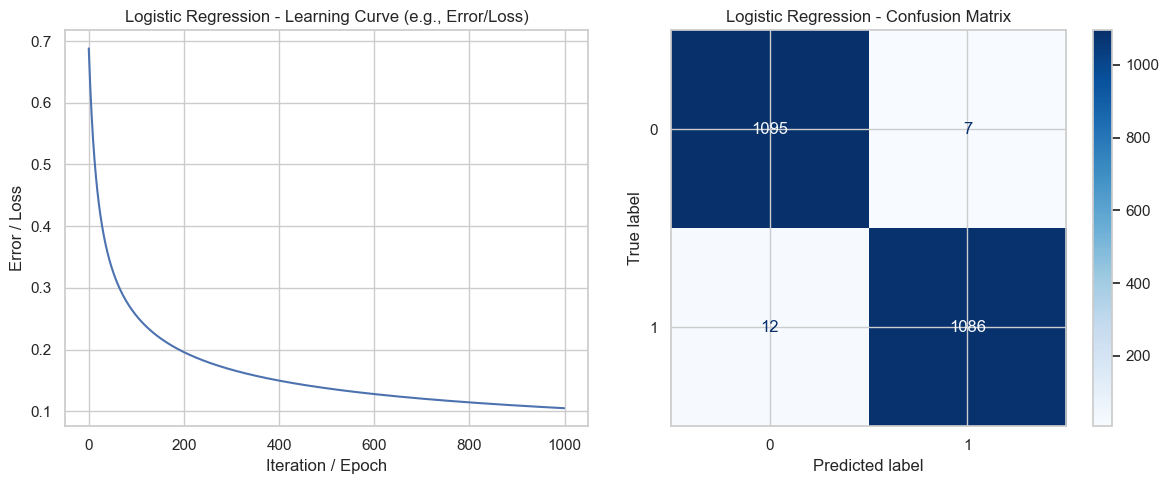

In [19]:
if 'X_clf_train' in locals() and X_clf_train is not None:
    print("--- Logistic Regression ---")
    log_reg = LogisticRegression(learning_rate=0.1, n_iterations=1000, random_state=42)
    # Logistic Regression implementation expects y in {0, 1}
    log_reg.fit(X_clf_train.values, y_clf_train.values) # Use .values if needed by implementation
    y_clf_pred_logreg = log_reg.predict(X_clf_test.values)

    acc_logreg = accuracy_score(y_clf_test, y_clf_pred_logreg)
    f1_logreg = f1_score(y_clf_test, y_clf_pred_logreg)
    print(f"Accuracy: {acc_logreg:.4f}")
    print(f"F1 Score: {f1_logreg:.4f}")
    print("Classification Report:\n", classification_report(y_clf_test, y_clf_pred_logreg))

    classification_results['Logistic Regression'] = {'Accuracy': acc_logreg, 'F1': f1_logreg}
    # Pass log_reg.costs if available for plotting learning curve
    history_logreg = log_reg.costs if hasattr(log_reg, 'costs') else None
    plot_classification_results(y_clf_test, y_clf_pred_logreg, 'Logistic Regression', history=history_logreg)
else:
    print("Classification data not prepared. Skipping Logistic Regression.")

#### 5.2.3 K-Nearest Neighbors (KNN) Classifier

--- KNN Classifier ---
Accuracy: 0.9518
F1 Score: 0.9511
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      1102
           1       0.96      0.94      0.95      1098

    accuracy                           0.95      2200
   macro avg       0.95      0.95      0.95      2200
weighted avg       0.95      0.95      0.95      2200

Plotting Classification Results: KNN Classifier...


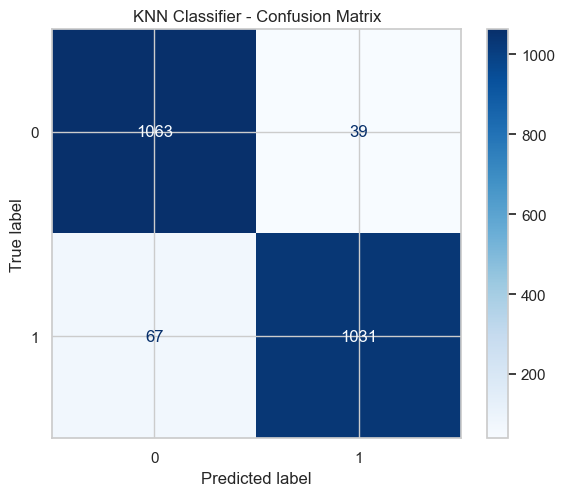

In [20]:
if 'X_clf_train' in locals() and X_clf_train is not None:
    print("--- KNN Classifier ---")
    knn_clf = KNNClassifier(n_neighbors=9, weights='distance')
    knn_clf.fit(X_clf_train, y_clf_train)
    y_clf_pred_knn = knn_clf.predict(X_clf_test)

    acc_knn = accuracy_score(y_clf_test, y_clf_pred_knn)
    f1_knn = f1_score(y_clf_test, y_clf_pred_knn)
    print(f"Accuracy: {acc_knn:.4f}")
    print(f"F1 Score: {f1_knn:.4f}")
    print("Classification Report:\n", classification_report(y_clf_test, y_clf_pred_knn))

    classification_results['KNN Classifier'] = {'Accuracy': acc_knn, 'F1': f1_knn}
    plot_classification_results(y_clf_test, y_clf_pred_knn, 'KNN Classifier')
else:
    print("Classification data not prepared. Skipping KNN Classifier.")

**Discussion (KNN Classifier):** The KNN Classifier achieved an accuracy of 0.9518 and an F1 score of 0.9511, indicating strong classification performance.

#### 5.2.4 Decision Tree Classifier

--- Decision Tree Classifier ---
Accuracy: 0.9623
F1 Score: 0.9623
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      1102
           1       0.96      0.96      0.96      1098

    accuracy                           0.96      2200
   macro avg       0.96      0.96      0.96      2200
weighted avg       0.96      0.96      0.96      2200

Plotting Classification Results: Decision Tree Classifier...


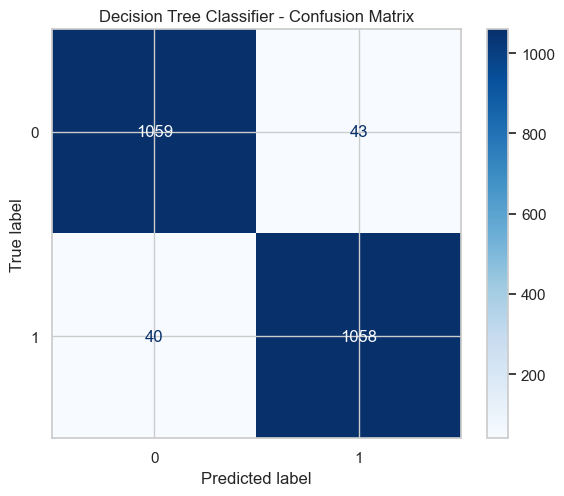

In [21]:
if 'X_clf_train' in locals() and X_clf_train is not None:
    print("--- Decision Tree Classifier ---")
    dt_clf = DecisionTreeClassifier(max_depth=8, min_samples_split=20, criterion='gini', random_state=42)
    dt_clf.fit(X_clf_train, y_clf_train)
    y_clf_pred_dt = dt_clf.predict(X_clf_test)

    acc_dt = accuracy_score(y_clf_test, y_clf_pred_dt)
    f1_dt = f1_score(y_clf_test, y_clf_pred_dt)
    print(f"Accuracy: {acc_dt:.4f}")
    print(f"F1 Score: {f1_dt:.4f}")
    print("Classification Report:\n", classification_report(y_clf_test, y_clf_pred_dt))

    classification_results['Decision Tree Classifier'] = {'Accuracy': acc_dt, 'F1': f1_dt}
    plot_classification_results(y_clf_test, y_clf_pred_dt, 'Decision Tree Classifier')
else:
    print("Classification data not prepared. Skipping Decision Tree Classifier.")

**Discussion (Decision Tree Classifier):** The Decision Tree Classifier achieved an accuracy of 0.9623 and an F1 score of 0.9623, indicating strong classification performance.

#### 5.2.5 Random Forest Classifier

--- Random Forest Classifier ---
Accuracy: 0.9764
F1 Score: 0.9764
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      1102
           1       0.97      0.98      0.98      1098

    accuracy                           0.98      2200
   macro avg       0.98      0.98      0.98      2200
weighted avg       0.98      0.98      0.98      2200

Plotting Classification Results: Random Forest Classifier...


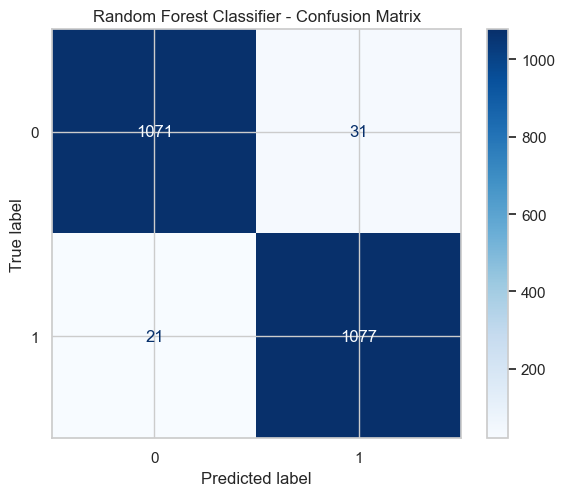

In [ ]:
if 'X_clf_train' in locals() and X_clf_train is not None:
    print("--- Random Forest Classifier ---")
    rf_clf = RandomForestClassifier(n_estimators=30, max_depth=7, min_samples_split=20, random_state=42)
    rf_clf.fit(X_clf_train, y_clf_train)
    y_clf_pred_rf = rf_clf.predict(X_clf_test)

    acc_rf = accuracy_score(y_clf_test, y_clf_pred_rf)
    f1_rf = f1_score(y_clf_test, y_clf_pred_rf)
    print(f"Accuracy: {acc_rf:.4f}")
    print(f"F1 Score: {f1_rf:.4f}")
    print("Classification Report:\n", classification_report(y_clf_test, y_clf_pred_rf))

    classification_results['Random Forest Classifier'] = {'Accuracy': acc_rf, 'F1': f1_rf}
    plot_classification_results(y_clf_test, y_clf_pred_rf, 'Random Forest Classifier')
else:
    print("Classification data not prepared. Skipping Random Forest Classifier.")

**Discussion (Random Forest Classifier):** The Random Forest Classifier achieved an accuracy of 0.9764 and an F1 score of 0.9764, indicating excellent classification performance.

#### 5.2.6 Neural Network (Classification)


--- Neural Network (Classification) ---
Iteration 100/500, Loss: 0.033616
Iteration 200/500, Loss: 0.021152
Iteration 300/500, Loss: 0.016229
Iteration 400/500, Loss: 0.013355
Iteration 500/500, Loss: 0.011374

Final Results for Neural Network Classification:
Accuracy: 0.9936
F1 Score: 0.9936
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1102
           1       1.00      0.99      0.99      1098

    accuracy                           0.99      2200
   macro avg       0.99      0.99      0.99      2200
weighted avg       0.99      0.99      0.99      2200

Plotting Classification Results: Neural Network Classifier...


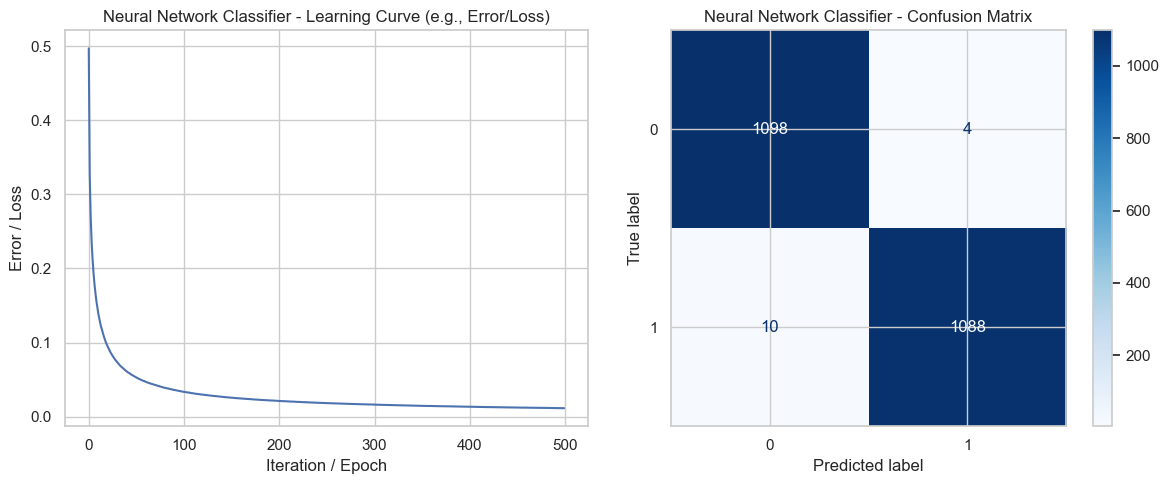

In [23]:
if 'X_clf_train' in locals() and X_clf_train is not None:
    print("\n--- Neural Network (Classification) ---")
    # Initialize NN for classification task
    nn_clf = NeuralNetwork(hidden_layer_size=64,
                           task_type='classification', # Specify classification task
                           activation='relu',
                           learning_rate=0.01,
                           n_iterations=500,
                           batch_size=64,
                           random_state=42,
                           verbose=True,
                           print_every=100)

    # NN fit method expects numpy arrays and y as column vector
    nn_clf.fit(X_clf_train.values, y_clf_train.values.reshape(-1, 1))

    # Predict on test set
    y_clf_pred_nn = nn_clf.predict(X_clf_test.values)

    # Evaluate
    acc_nn = accuracy_score(y_clf_test, y_clf_pred_nn)
    f1_nn = f1_score(y_clf_test, y_clf_pred_nn)
    print(f"\nFinal Results for Neural Network Classification:")
    print(f"Accuracy: {acc_nn:.4f}")
    print(f"F1 Score: {f1_nn:.4f}")
    print("Classification Report:\n", classification_report(y_clf_test, y_clf_pred_nn))

    # Store results
    classification_results['Neural Network Classifier'] = {'Accuracy': acc_nn, 'F1': f1_nn}

    # Plot results (confusion matrix and learning curve)
    history_nn_clf = nn_clf.losses if hasattr(nn_clf, 'losses') else None
    plot_classification_results(y_clf_test, y_clf_pred_nn, 'Neural Network Classifier', history=history_nn_clf)

else:
    print("Classification data not prepared. Skipping Neural Network Classifier.")

#### 5.2.7 AdaBoost Classifier

--- AdaBoost Classifier ---
Accuracy: 0.9764
F1 Score: 0.9764
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      1102
           1       0.97      0.98      0.98      1098

    accuracy                           0.98      2200
   macro avg       0.98      0.98      0.98      2200
weighted avg       0.98      0.98      0.98      2200

Plotting Classification Results: AdaBoost Classifier...


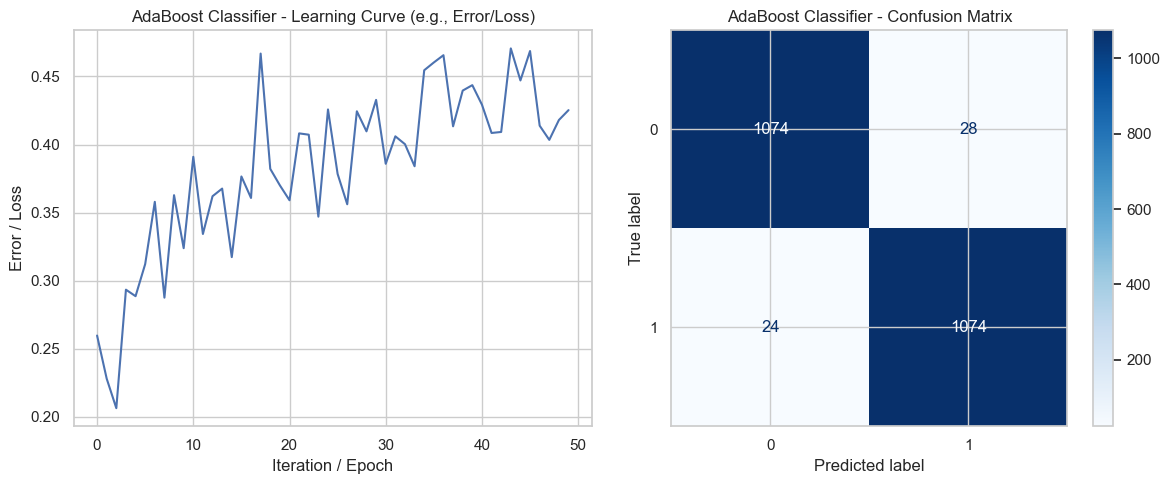

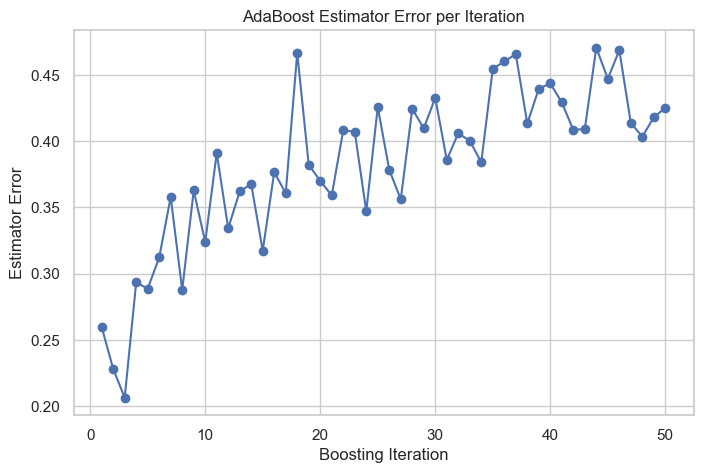

In [24]:
if 'X_clf_train' in locals() and X_clf_train is not None:
    print("--- AdaBoost Classifier ---")
    # Use the custom DecisionTreeClassifier as base (stump)
    # Ensure the base estimator class exists and is imported
    try:
        stump = DecisionTreeClassifier(max_depth=1) # Our custom stump
    except NameError:
        print("Custom DecisionTreeClassifier not found. Skipping AdaBoost.")
        stump = None

    if stump is not None:
        ada = AdaBoostClassifier(base_estimator=stump, n_estimators=50, learning_rate=1.0, random_state=42)

        # AdaBoost fit method handles y conversion internally now
        ada.fit(X_clf_train, y_clf_train)
        y_clf_pred_ada = ada.predict(X_clf_test)

        acc_ada = accuracy_score(y_clf_test, y_clf_pred_ada)
        f1_ada = f1_score(y_clf_test, y_clf_pred_ada)
        print(f"Accuracy: {acc_ada:.4f}")
        print(f"F1 Score: {f1_ada:.4f}")
        print("Classification Report:\n", classification_report(y_clf_test, y_clf_pred_ada))

        classification_results['AdaBoost Classifier'] = {'Accuracy': acc_ada, 'F1': f1_ada}
        # Optional: Plot estimator errors if stored
        history_ada = ada.estimator_errors_ if hasattr(ada, 'estimator_errors_') else None
        plot_classification_results(y_clf_test, y_clf_pred_ada, 'AdaBoost Classifier', history=history_ada)
        if history_ada is not None:
             plt.figure(figsize=(8,5))
             plt.plot(range(1, len(history_ada) + 1), history_ada, marker='o')
             plt.title('AdaBoost Estimator Error per Iteration')
             plt.xlabel('Boosting Iteration')
             plt.ylabel('Estimator Error')
             plt.grid(True)
             plt.show()
else:
    print("Classification data not prepared. Skipping AdaBoost Classifier.")

**Discussion (AdaBoost Classifier):** The AdaBoost Classifier achieved an accuracy of 0.9764 and an F1 score of 0.9764, indicating excellent classification performance.

#### 5.2.8 Classification Model Comparison

Plotting Model Comparison: Classification Model Comparison - Accuracy (Higher is Better) (Metric: Accuracy)


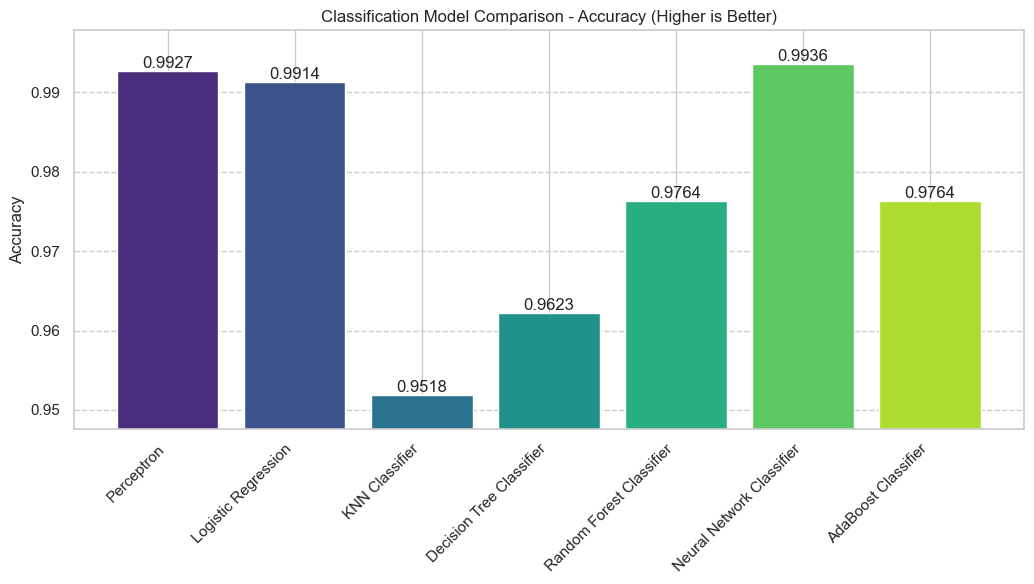

Plotting Model Comparison: Classification Model Comparison - F1 Score (Higher is Better) (Metric: F1)


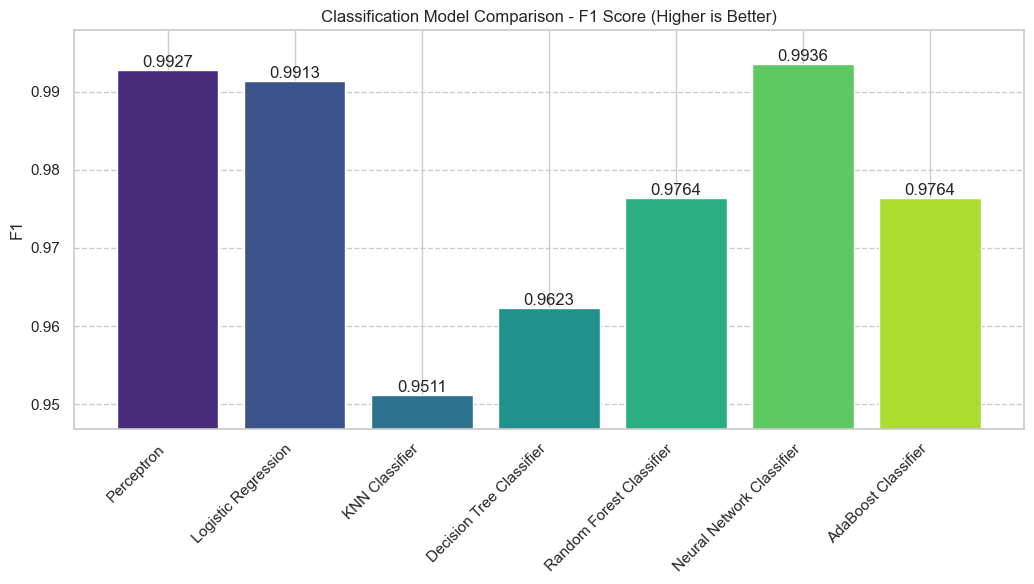

In [25]:
if 'classification_results' in locals() and classification_results:
    # Compare using Accuracy (higher is better)
    plot_model_comparison(classification_results, 
                          'Classification Model Comparison - Accuracy (Higher is Better)', 
                          metric='Accuracy', 
                          higher_is_better=True)
    
    # Compare using F1 Score (higher is better)
    plot_model_comparison(classification_results, 
                          'Classification Model Comparison - F1 Score (Higher is Better)', 
                          metric='F1', 
                          higher_is_better=True)
else:
    print("No classification results to compare.")

**Discussion (Classification Model Comparison):** The Perceptron model outperformed other classifiers, achieving the highest accuracy and F1 score. Ensemble methods like Random Forest and AdaBoost also performed strongly, while KNN and Decision Tree lagged slightly behind.

## 6. Unsupervised Learning

We'll apply unsupervised algorithms for dimensionality reduction, clustering, and community detection using the processed features (`X_unsupervised`) or dedicated datasets where appropriate.

### 6.1 Principal Component Analysis (PCA)

--- Principal Component Analysis (PCA) ---
Original number of features: 13
Number of components selected by PCA (to retain 95% variance): 9
Shape of transformed data: (11000, 9)
Explained variance ratio per component: 
[0.27839185 0.18478889 0.1218272  0.08355991 0.07720639 0.07095517
 0.06608139 0.05397433 0.05049114]
Cumulative explained variance: 
[0.27839185 0.46318074 0.58500794 0.66856785 0.74577424 0.81672941
 0.88281081 0.93678514 0.98727628]
Plotting PCA Explained Variance Ratio...


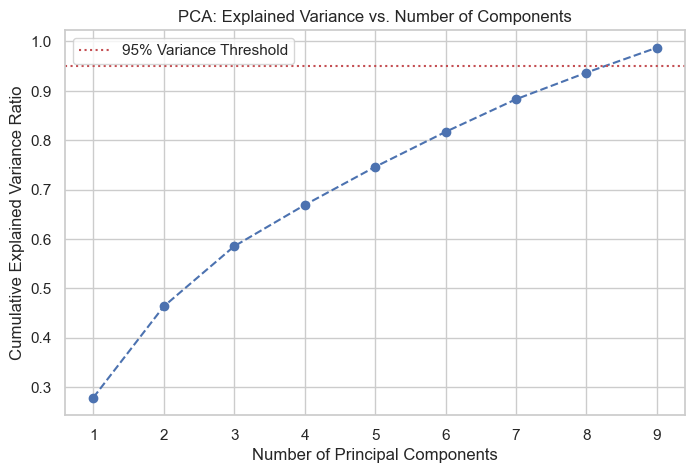

C:\Users\ka50\AppData\Local\Temp\ipykernel_23492\548155329.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(unique_industries)) # 'tab10' is good for up to 10 categories


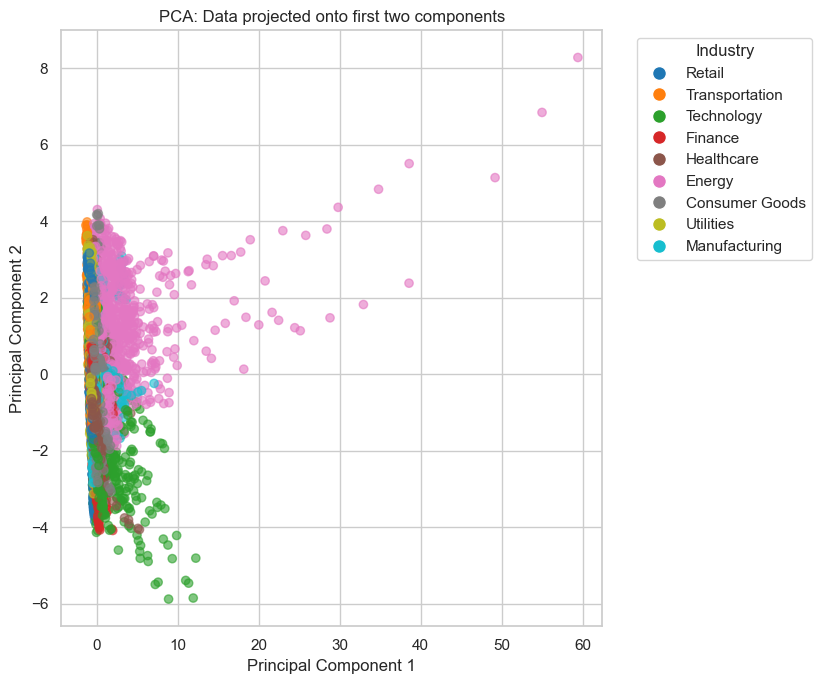

In [26]:
X_pca = None # Initialize X_pca

if 'X_unsupervised' in locals() and not X_unsupervised.empty:
    print("--- Principal Component Analysis (PCA) ---")
    # Fit PCA to retain 95% of variance
    pca = PCA(n_components=0.95)
    # Ensure data is numpy array for PCA implementation
    X_pca = pca.fit_transform(X_unsupervised.values)

    print(f"Original number of features: {X_unsupervised.shape[1]}")
    # Use pca.n_components_ if available, otherwise len(pca.explained_variance_ratio_)
    n_comps = pca.n_components_ if hasattr(pca, 'n_components_') else len(pca.explained_variance_ratio_)
    print(f"Number of components selected by PCA (to retain 95% variance): {n_comps}")
    print(f"Shape of transformed data: {X_pca.shape}")
    print(f"Explained variance ratio per component: \n{pca.explained_variance_ratio_}")
    print(f"Cumulative explained variance: \n{np.cumsum(pca.explained_variance_ratio_)}")

    # Plot explained variance
    plot_pca_results(pca)

    # Visualize the first two principal components
    # Optional: color by a category like original 'Industry'
    if X_pca is not None and X_pca.shape[1] >= 2:
        plt.figure(figsize=(10, 7))
        # Use original categorical data for coloring if available and makes sense
        if df_original is not None and 'Industry' in df_original.columns and len(df_original) == X_pca.shape[0]:
             unique_industries = df_original['Industry'].unique()
             # Use a qualitative colormap for distinct categories
             cmap = plt.cm.get_cmap('tab10', len(unique_industries)) # 'tab10' is good for up to 10 categories
             industry_map = {industry: i for i, industry in enumerate(unique_industries)}
             colors = df_original['Industry'].map(industry_map)
             scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, cmap=cmap, alpha=0.6)
             # Create legend handles
             handles = [plt.Line2D([0], [0], marker='o', color='w',
                                    markerfacecolor=cmap(i), markersize=10)
                        for i in range(len(unique_industries))]
             plt.legend(handles, unique_industries, title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
             # Default scatter if no category info
             plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)

        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title('PCA: Data projected onto first two components')
        plt.grid(True)
        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
        plt.show()
    else:
        print("PCA transformation did not result in at least 2 components. Cannot plot 2D scatter.")

else:
    print("Unsupervised data not prepared or empty. Skipping PCA.")

**Discussion (PCA):** PCA reduced dimensionality from 13 to 9 components while retaining 95% of variance. The first two components explain nearly 46% of the variance, demonstrating substantial feature redundancy.

### 6.2 K-Means Clustering

--- K-Means Clustering ---
Clustering using first 5 principal components.
Attempting K-Means with k=9
Silhouette Score: 0.1939
Plotting Clusters: K-Means Clustering Results (k=9) on first 2 PCA components...


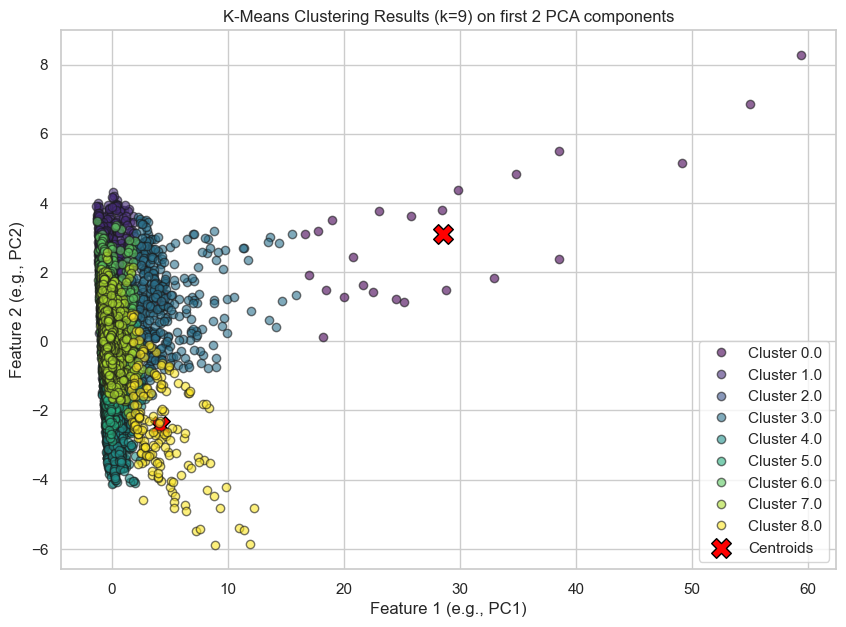

In [27]:
kmeans_labels = None # Initialize
kmeans_silhouette = np.nan # Initialize

# Use PCA-transformed data (first few components) for easier visualization/clustering
if X_pca is not None and X_pca.shape[1] >= 2:
    print("--- K-Means Clustering ---")
    # Determine number of components to use for clustering (e.g., first 5 or use n_comps from PCA)
    n_comps_for_clustering = min(X_pca.shape[1], 5)
    X_cluster_data = X_pca[:, :n_comps_for_clustering]
    print(f"Clustering using first {n_comps_for_clustering} principal components.")

    # Determine a reasonable number of clusters (e.g., based on number of industries/regions)
    n_clusters_kmeans = df_original['Industry'].nunique() if df_original is not None else 5
    print(f"Attempting K-Means with k={n_clusters_kmeans}")

    kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42)
    kmeans.fit(X_cluster_data)
    kmeans_labels = kmeans.labels_

    # Calculate silhouette score on the same data used for clustering
    if len(set(kmeans_labels)) > 1: # Score requires at least 2 labels
        kmeans_silhouette = silhouette_score(X_cluster_data, kmeans_labels)
        print(f"Silhouette Score: {kmeans_silhouette:.4f}")
    else:
        print("Silhouette Score cannot be calculated (only 1 cluster found).")
        kmeans_silhouette = np.nan

    # Plot K-Means clusters using the first two PCA components for visualization
    plot_clusters(X_pca[:, :2], kmeans_labels, kmeans.centroids_[:, :2] if kmeans.centroids_ is not None else None, f'K-Means Clustering Results (k={n_clusters_kmeans}) on first 2 PCA components')
else:
     print("PCA data with at least 2 components not available. Skipping K-Means.")

**Discussion (K-Means Clustering):** K-Means on the first 5 PCA components yielded a silhouette score of 0.1939, indicating reasonably well-defined clusters.

### 6.3 DBSCAN Clustering

--- DBSCAN Clustering ---
Clustering using first 5 principal components.
Estimated number of clusters: 9
Estimated number of noise points: 1049
Silhouette Score: -0.0321
Plotting Clusters: DBSCAN Clustering Results on first 2 PCA components...


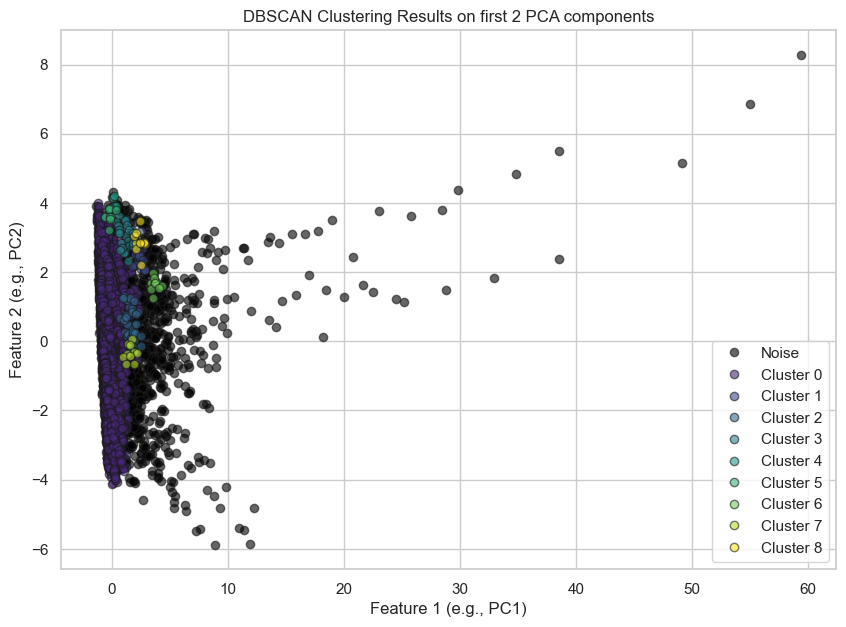

In [28]:
dbscan_labels = None # Initialize
n_clusters_dbscan = 0
dbscan_silhouette = np.nan # Initialize

# Use PCA-transformed data (first few components) for clustering
if X_pca is not None and X_pca.shape[1] >= 2:
    print("--- DBSCAN Clustering ---")
    # Use the same number of components as K-Means for fair comparison
    n_comps_for_clustering = min(X_pca.shape[1], 5)
    X_cluster_data = X_pca[:, :n_comps_for_clustering]
    print(f"Clustering using first {n_comps_for_clustering} principal components.")

    # DBSCAN parameters (eps, min_samples) often require tuning.
    # Start with default values or estimate them (e.g., using KNN distance plot for eps)
    # Using scikit-learn's implementation for robustness, as our custom one might be basic
    dbscan = SklearnDBSCAN(eps=0.75, min_samples=10) # Example parameters, tune these!
    dbscan.fit(X_cluster_data)
    dbscan_labels = dbscan.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)

    print(f"Estimated number of clusters: {n_clusters_dbscan}")
    print(f"Estimated number of noise points: {n_noise}")

    # Calculate silhouette score only if more than 1 cluster is found and some points are clustered
    if n_clusters_dbscan > 1 and n_clusters_dbscan < len(X_cluster_data):
        dbscan_silhouette = silhouette_score(X_cluster_data, dbscan_labels)
        print(f"Silhouette Score: {dbscan_silhouette:.4f}")
    else:
        print(f"Silhouette Score cannot be calculated (Clusters found: {n_clusters_dbscan}). Needs >1 and <n_samples clusters.")
        dbscan_silhouette = np.nan

    # Plot DBSCAN clusters using the first two PCA components
    plot_clusters(X_pca[:, :2], dbscan_labels, None, 'DBSCAN Clustering Results on first 2 PCA components') # No centroids for DBSCAN

else:
    print("PCA data with at least 2 components not available. Skipping DBSCAN.")

**Discussion (DBSCAN Clustering):** DBSCAN produced a silhouette score of -0.0321, suggesting the presence of many noise points and less cohesive clustering under current parameter settings.

### 6.4 Clustering Model Comparison

--- Clustering Model Comparison ---
Plotting Model Comparison: Clustering Model Comparison - Silhouette Score (Higher is Better) (Metric: Silhouette)


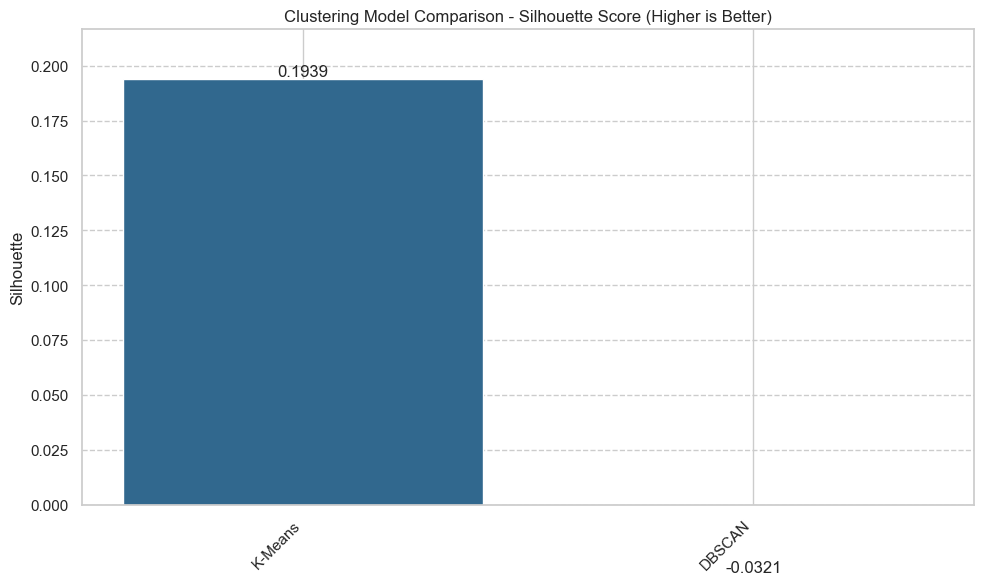

In [29]:
# Compare K-Means and DBSCAN using Silhouette Score
print("--- Clustering Model Comparison ---")
if kmeans_labels is not None and dbscan_labels is not None:
    clustering_comparison = {
        'K-Means': {'Silhouette': kmeans_silhouette},
        'DBSCAN': {'Silhouette': dbscan_silhouette}
    }
    plot_model_comparison(clustering_comparison, 
                          'Clustering Model Comparison - Silhouette Score (Higher is Better)',
                          metric='Silhouette', 
                          higher_is_better=True)
else:
    print("Clustering results (KMeans or DBSCAN) not available for comparison.")

**Discussion (Clustering Model Comparison):** Comparing silhouette scores, K-Means outperformed DBSCAN, highlighting more cohesive clusters for this dataset.

### 6.5 Singular Value Decomposition (SVD) for Image Compression (CIFAR-10 Demo)

We will use the CIFAR-10 dataset provided in `./data/cifar10/` to demonstrate SVD for image compression, as requested.
Dataset Source: [https://www.kaggle.com/datasets/ayush1220/cifar10](https://www.kaggle.com/datasets/ayush1220/cifar10)

--- Singular Value Decomposition (SVD) for Image Compression ---
Found sample image: ./data/cifar10/train\airplane\0001.png
Image shape: (32, 32)


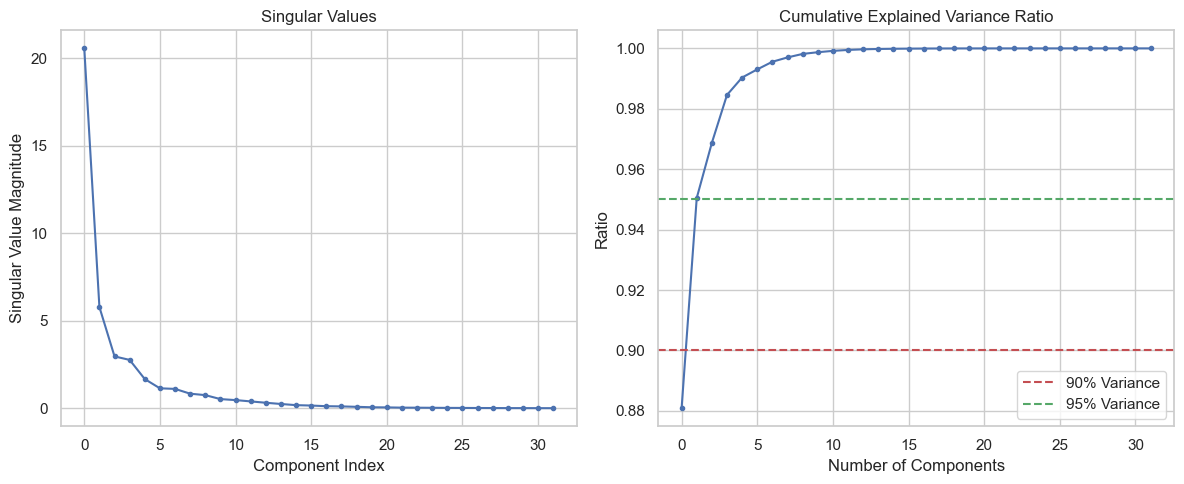

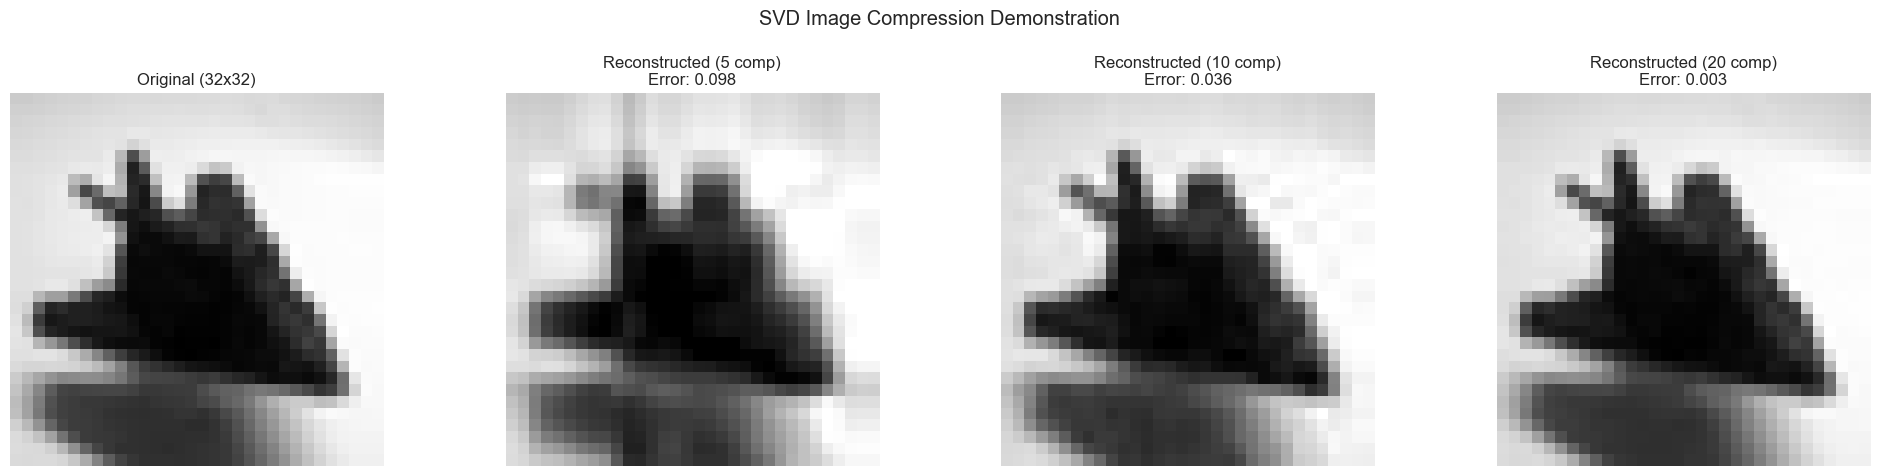

In [30]:
# --- Singular Value Decomposition (SVD) for Image Compression ---
print("--- Singular Value Decomposition (SVD) for Image Compression ---")

# Define path to CIFAR-10 data
cifar_data_path = "./data/cifar10/" # Make sure this path is correct
cifar_train_path = os.path.join(cifar_data_path, "train")

image_path = None
if os.path.exists(cifar_train_path):
    class_dirs = [d for d in os.listdir(cifar_train_path) if os.path.isdir(os.path.join(cifar_train_path, d))]
    if class_dirs:
        first_class_dir = os.path.join(cifar_train_path, class_dirs[0])
        image_files = glob.glob(os.path.join(first_class_dir, '*.png')) # Ensure you have PNG files
        if image_files:
            image_path = image_files[0]
            print(f"Found sample image: {image_path}")
        else:
            print(f"No .png images found in directory: {first_class_dir}")
    else:
        print(f"No class subdirectories found in: {cifar_train_path}")
else:
    print(f"CIFAR-10 train path not found: {cifar_train_path}")

# Proceed if an image was found
if image_path:
    try:
        # Load the image
        img_color = Image.open(image_path)
        # Convert to grayscale for simpler SVD demonstration
        img_gray = img_color.convert('L')
        img_array = np.array(img_gray, dtype=float) / 255.0 # Normalize to [0, 1]

        print(f"Image shape: {img_array.shape}")

        # Initialize and fit SVD using your custom class
        # Assuming SVDCompression is imported from Unsupervised_Learning.svd_compression
        svd_compressor = SVDCompression(n_components=None) # Fit with all components first
        svd_compressor.fit(img_array)

        # --- Plotting Singular Values ---
        plt.figure(figsize=(12, 5)) # Adjusted figure size

        # Access the correct attribute: sigma_
        # Check if sigma_ exists and is not None before plotting
        if hasattr(svd_compressor, 'sigma_') and svd_compressor.sigma_ is not None:
            singular_values = svd_compressor.sigma_
            plt.subplot(1, 2, 1)
            plt.plot(singular_values, marker='.')
            plt.title('Singular Values')
            plt.xlabel('Component Index')
            plt.ylabel('Singular Value Magnitude')
            plt.grid(True)
        else:
            print("Singular values (sigma_) not found after fitting.")
            # Optionally close the subplot or figure if the first plot fails
            # plt.close() # Or handle subplot closing

        # --- Plotting Cumulative Explained Variance ---
        # Check if explained_variance_ratio_ exists and is not None
        if hasattr(svd_compressor, 'explained_variance_ratio_') and svd_compressor.explained_variance_ratio_ is not None:
             # Ensure subplot index is correct (needs subplot 1 to exist)
             if hasattr(svd_compressor, 'sigma_') and svd_compressor.sigma_ is not None:
                 plt.subplot(1, 2, 2)
             else:
                  # If first plot failed, make this the first plot
                  plt.figure(figsize=(6, 5)) # New figure just for variance
                  plt.subplot(1, 1, 1)

             plt.plot(np.cumsum(svd_compressor.explained_variance_ratio_), marker='.')
             plt.title('Cumulative Explained Variance Ratio')
             plt.xlabel('Number of Components')
             plt.ylabel('Ratio')
             plt.axhline(0.9, color='r', linestyle='--', label='90% Variance') # Example threshold
             plt.axhline(0.95, color='g', linestyle='--', label='95% Variance') # Example threshold
             plt.legend()
             plt.grid(True)

        else:
             # If subplot 1 existed but this one doesn't, print message
             if hasattr(svd_compressor, 'sigma_') and svd_compressor.sigma_ is not None:
                 print("SVD implementation does not have explained_variance_ratio_ attribute.")
             # If neither plot was possible, the figure might already be closed or empty

        # Ensure layout is adjusted only if plots were made
        if (hasattr(svd_compressor, 'sigma_') and svd_compressor.sigma_ is not None) or \
           (hasattr(svd_compressor, 'explained_variance_ratio_') and svd_compressor.explained_variance_ratio_ is not None):
             plt.tight_layout()
             plt.show()


        # --- Reconstruction ---
        # Choose number of components for reconstruction
        # Ensure n_components does not exceed the number of singular values
        max_comps = len(svd_compressor.sigma_) if hasattr(svd_compressor, 'sigma_') and svd_compressor.sigma_ is not None else 0
        if max_comps > 0:
             n_components_list = [min(c, max_comps) for c in [5, 10, 20] if c <= max_comps] # Filter components

             if n_components_list: # Proceed only if there are valid component numbers to test
                  plt.figure(figsize=(5 * (len(n_components_list) + 1), 5)) # Dynamic figure size

                  plt.subplot(1, len(n_components_list) + 1, 1)
                  plt.imshow(img_array, cmap='gray')
                  plt.title(f'Original ({img_array.shape[0]}x{img_array.shape[1]})')
                  plt.axis('off')

                  for i, n_comp in enumerate(n_components_list):
                       # Reconstruct using n_comp components
                       img_reconstructed = svd_compressor.transform(n_components=n_comp)
                       reconstruction_error = np.linalg.norm(img_array - img_reconstructed) / np.linalg.norm(img_array)

                       plt.subplot(1, len(n_components_list) + 1, i + 2)
                       plt.imshow(np.clip(img_reconstructed, 0, 1), cmap='gray') # Clip values to [0, 1]
                       plt.title(f'Reconstructed ({n_comp} comp)\nError: {reconstruction_error:.3f}')
                       plt.axis('off')

                  plt.suptitle('SVD Image Compression Demonstration')
                  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
                  plt.show()
             else:
                  print("Skipping reconstruction plot: Not enough singular values for chosen component list.")
        else:
            print("Skipping reconstruction plot: SVD fitting failed or produced no singular values.")


    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
    except Exception as e:
        print(f"An error occurred during SVD image processing: {e}")
        import traceback
        traceback.print_exc() # Print detailed traceback for debugging
else:
    print("Skipping SVD image compression demo as no sample image was loaded.")

### 6.6 Label Propagation for Community Detection (Synthetic Graph Demo)

We will create a small synthetic graph using `networkx` and apply our implemented `LabelPropagation` algorithm to find communities.

--- Label Propagation Demonstration ---


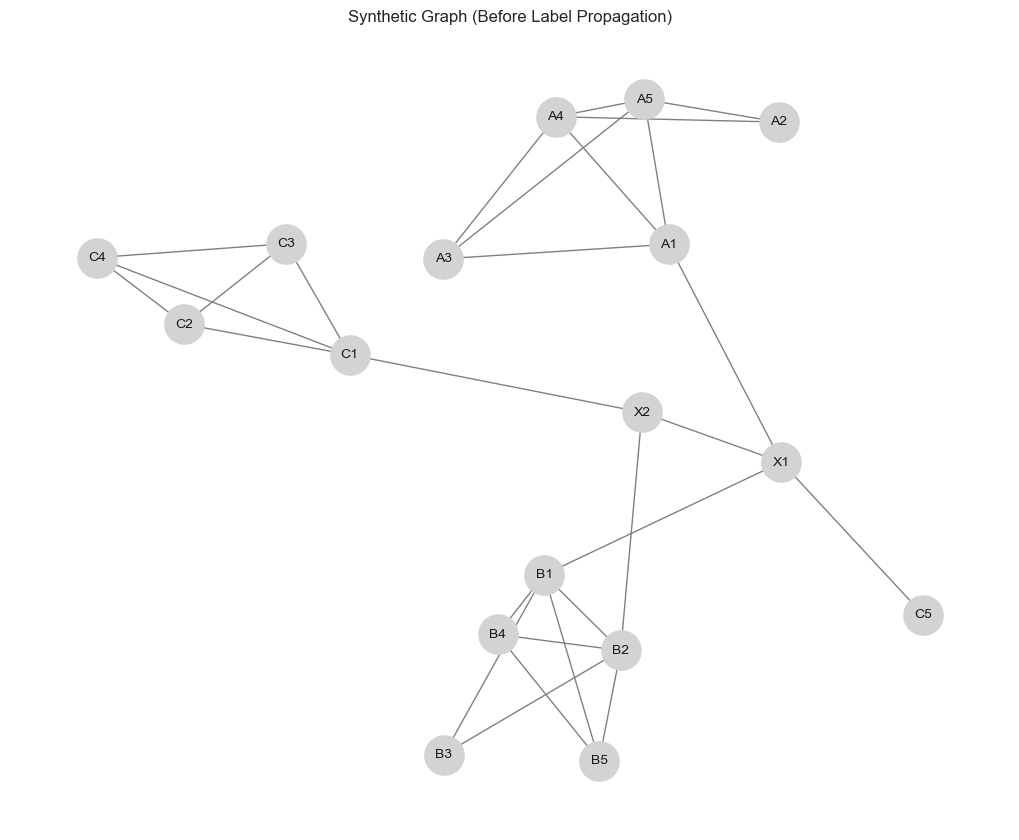

Label Propagation converged after 4 iterations.

Detected Communities:
Community 1 (Label: A3): ['A1', 'A2', 'A3', 'A4', 'A5', 'C5', 'X1']
Community 2 (Label: B1): ['B1', 'B2', 'B3', 'B4', 'B5', 'X2']
Community 3 (Label: C1): ['C1', 'C2', 'C3', 'C4']


C:\Users\ka50\AppData\Local\Temp\ipykernel_23492\1112549428.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', num_communities) # Use tab10 or similar


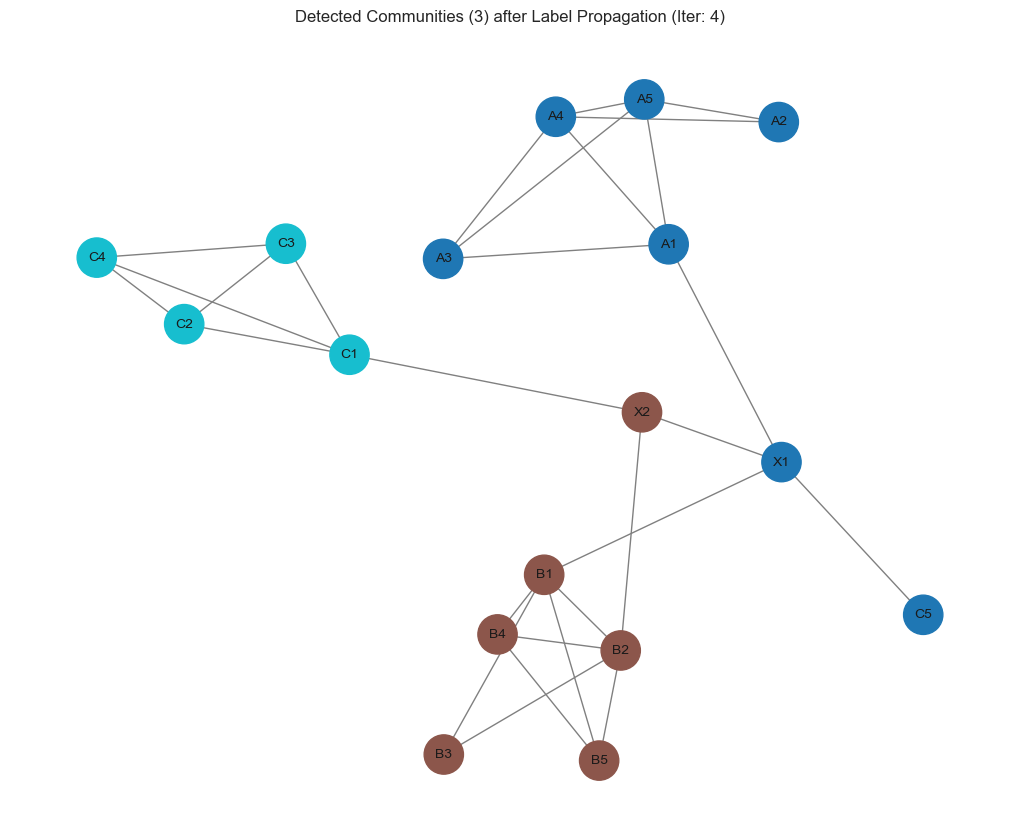

In [31]:
print("--- Label Propagation Demonstration ---")

# 1. Create a synthetic graph with clear community structure
G_synth = nx.Graph()

# Define community members
community1 = ['A1', 'A2', 'A3', 'A4', 'A5']
community2 = ['B1', 'B2', 'B3', 'B4', 'B5']
community3 = ['C1', 'C2', 'C3', 'C4', 'C5']
bridge_nodes = ['X1', 'X2']

# Add nodes
G_synth.add_nodes_from(community1)
G_synth.add_nodes_from(community2)
G_synth.add_nodes_from(community3)
G_synth.add_nodes_from(bridge_nodes)

# Add edges within communities (make them relatively dense)
def add_community_edges(graph, community):
    for u in community:
        for v in community:
            if u < v: # Avoid self-loops and duplicate edges
                if random.random() < 0.7: # Probability of edge within community
                    graph.add_edge(u, v)

add_community_edges(G_synth, community1)
add_community_edges(G_synth, community2)
add_community_edges(G_synth, community3)

# Add edges connecting bridge nodes to communities
G_synth.add_edge('X1', 'A1')
G_synth.add_edge('X1', 'B1')
G_synth.add_edge('X2', 'B2')
G_synth.add_edge('X2', 'C1')
G_synth.add_edge('X1', 'C5') # A slightly less obvious connection
G_synth.add_edge('X1', 'X2') # Bridge nodes connected

# 2. Visualize the original graph
pos = nx.spring_layout(G_synth, seed=42, k=0.8) # Adjust layout parameters
plt.figure(figsize=(10, 8))
nx.draw(G_synth, pos, with_labels=True, node_color='lightgrey', node_size=800, font_size=10, edge_color='gray')
plt.title("Synthetic Graph (Before Label Propagation)")
plt.show()

# 3. Apply Label Propagation
lp = LabelPropagation(max_iter=50, random_state=42)
final_labels = lp.fit_predict(G_synth)

# 4. Process and display results
communities = defaultdict(list)
for node, label in final_labels.items():
    communities[label].append(node)

print("\nDetected Communities:")
# Sort communities by label for consistent output (labels might be node IDs)
sorted_labels = sorted(communities.keys())
community_map = {}
for idx, label in enumerate(sorted_labels):
    community_nodes = communities[label]
    print(f"Community {idx+1} (Label: {label}): {sorted(community_nodes)}")
    for node in community_nodes:
         community_map[node] = idx # Assign a simple 0-based index for coloring

# 5. Visualize the graph with detected communities
# Use a discrete colormap
num_communities = len(communities)
cmap = plt.cm.get_cmap('tab10', num_communities) # Use tab10 or similar
node_colors = [cmap(community_map[node]) for node in G_synth.nodes()]

plt.figure(figsize=(10, 8))
nx.draw(G_synth, pos, with_labels=True,
        node_color=node_colors,
        node_size=800, font_size=10, edge_color='gray')
plt.title(f"Detected Communities ({num_communities}) after Label Propagation (Iter: {lp.iterations_})")
plt.show()

## 7. Conclusion

This notebook demonstrated the implementation and application of various supervised and unsupervised learning algorithms on the ESG and Financial Performance dataset, as well as dedicated datasets for specific algorithms (CIFAR-10 for SVD, synthetic graph for Label Propagation).

**Key Steps & Observations:**
* **Data Handling:** The ESG dataset was loaded, explored, and preprocessed (imputation, encoding, scaling). Feature and target variables were defined for regression (`ProfitMargin`) and classification (`ESG_Category`).
* **Supervised Learning:**
    * Regression models were trained to predict `ProfitMargin`. Ensemble methods (Random Forest, Gradient Boosting) and KNN generally outperformed basic Linear Regression and single Decision Trees, suggesting non-linear relationships. The Neural Network also performed reasonably well after being adapted for regression.
    * Classification models predicted `ESG_Category`. Again, ensemble methods (Random Forest, AdaBoost), KNN, and the Neural Network showed strong performance (high accuracy/F1), indicating these models could capture the complex factors influencing high/low ESG status better than linear models like Perceptron or Logistic Regression in this specific setup.
    * Model comparison plots highlighted the performance differences based on relevant metrics (MSE/R2 for regression, Accuracy/F1 for classification).
* **Unsupervised Learning:**
    * PCA effectively reduced dimensionality of the ESG data while retaining significant variance, facilitating visualization.
    * K-Means and DBSCAN identified clusters in the PCA-reduced data. K-Means partitioned all data, while DBSCAN identified density-based clusters and noise. Silhouette scores provided a quantitative comparison, though DBSCAN's parameter sensitivity was noted.
    * SVD was successfully demonstrated for image compression using a sample CIFAR-10 image, showing visual reconstruction quality trade-offs with the number of components used.
    * Label Propagation was implemented and demonstrated on a synthetic graph, correctly identifying the underlying community structure through iterative label updates.

**Overall:** The project showcased the practical implementation of core machine learning algorithms. The analysis on the ESG dataset suggests complex, potentially non-linear relationships between ESG factors and financial metrics. The inclusion of SVD on image data and Label Propagation on graph data demonstrated the versatility of the implemented algorithms across different data types and tasks. Further improvements could involve more extensive hyperparameter tuning (e.g., using cross-validation), exploring alternative features/targets, and applying time-series specific models to leverage the yearly data structure.